# Preliminaries operations


In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddos-dataset/ddos_dataset.csv


In [23]:
# import needed python libraries

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.manifold import TSNE

# read data
ddos_data = pd.read_csv("/kaggle/input/ddos-dataset/ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

# set Flow ID
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' +
                         ddos_data['Destination Port'].astype(str) + ' - ' +
                         ddos_data['Timestamp'].astype(str) )
ddos_data = ddos_data.set_index("Flow ID")

#  categorical SimillarHTTP
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes

# delete rubbish
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

# delete varancie null
variance = ddos_data.var(numeric_only=True)
zero_variance = variance[variance == 0].index
ddos_data.drop(zero_variance, axis=1, inplace=True)

# one-hot encode Protocol
mask_udp = ddos_data['Protocol'] == 0
mask_tcp = ddos_data['Protocol'] == 6
mask_hopopt = ddos_data['Protocol'] == 17
ddos_data['Protocol 0'] = mask_udp.astype(int)
ddos_data['Protocol 6'] = mask_tcp.astype(int)
ddos_data['Protocol 17'] = mask_hopopt.astype(int)

# encode Port
frequencies = ddos_data['Destination Port'].value_counts()
ddos_data['Destination Port Freq'] = ddos_data['Destination Port'].map(frequencies)
frequencies = ddos_data['Source Port'].value_counts()
ddos_data['Source Port Freq'] = ddos_data['Source Port'].map(frequencies)

# delete features
ddos_data.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol"],
    axis=1,
    inplace=True)


# features selected in the first section
columns_to_remove = ['Active Max', 'Active Min', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Protocol 17', 'Protocol 6', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = ddos_data.drop(columns=columns_to_remove)
ddos_data.columns

# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set

ddos_data_temp = ddos_data.copy()
labels = pd.Categorical(ddos_data_temp['label']).codes

X = ddos_data_temp.drop(columns=['label']).to_numpy()
y = ddos_data_temp[['label']]

# Standardize data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)


# Kmeans training

In [38]:
# k-Means with n_clusters = 35
kmeans = KMeans(n_clusters=35,random_state=0) # Use fixed state for future analysis
cl_labels = kmeans.fit_predict(X_s) # Get clusters ID

# unsupervised metric
silhouette  = silhouette_score(X_s, cl_labels)
# supervised metrics
ri = rand_score(np.ravel(y), cl_labels)
ari = adjusted_rand_score(np.ravel(y), cl_labels)

print('k-Means with 35 clusters')
(unique, counts)=np.unique( cl_labels, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


k-Means with 35 clusters
Size of each cluster:  [ 8216 14869  1244   239  7357    27  3396  2016   538   472     1   512
    38     2     5  8441  2125    53  6155     1    37  4366   158    30
  1978   250   196     2   163   283   109     3   129   823     5]
k_means clustering error: 282283.04
Silhouette: 0.65
RI: 0.89
ARI: 0.42


# Distribution among clusters and labels


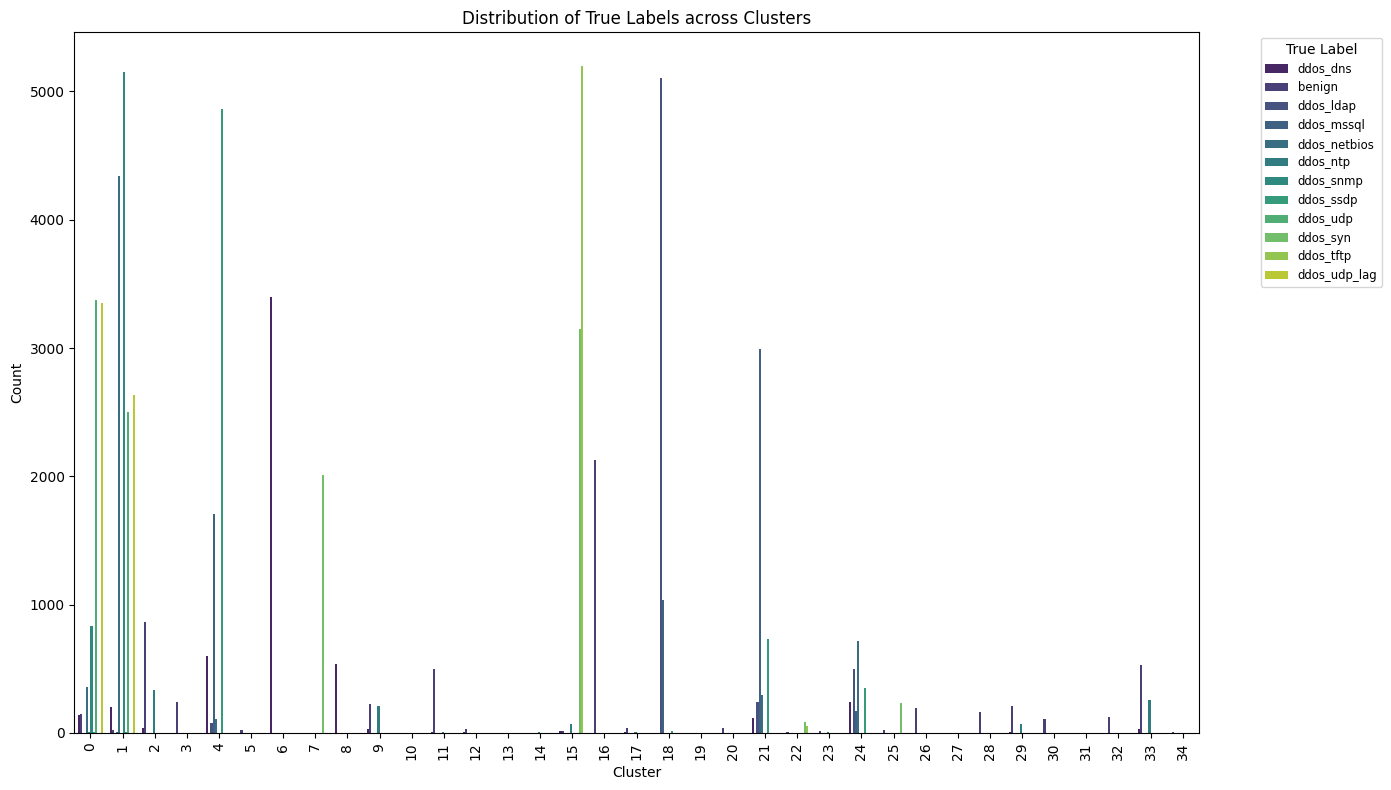

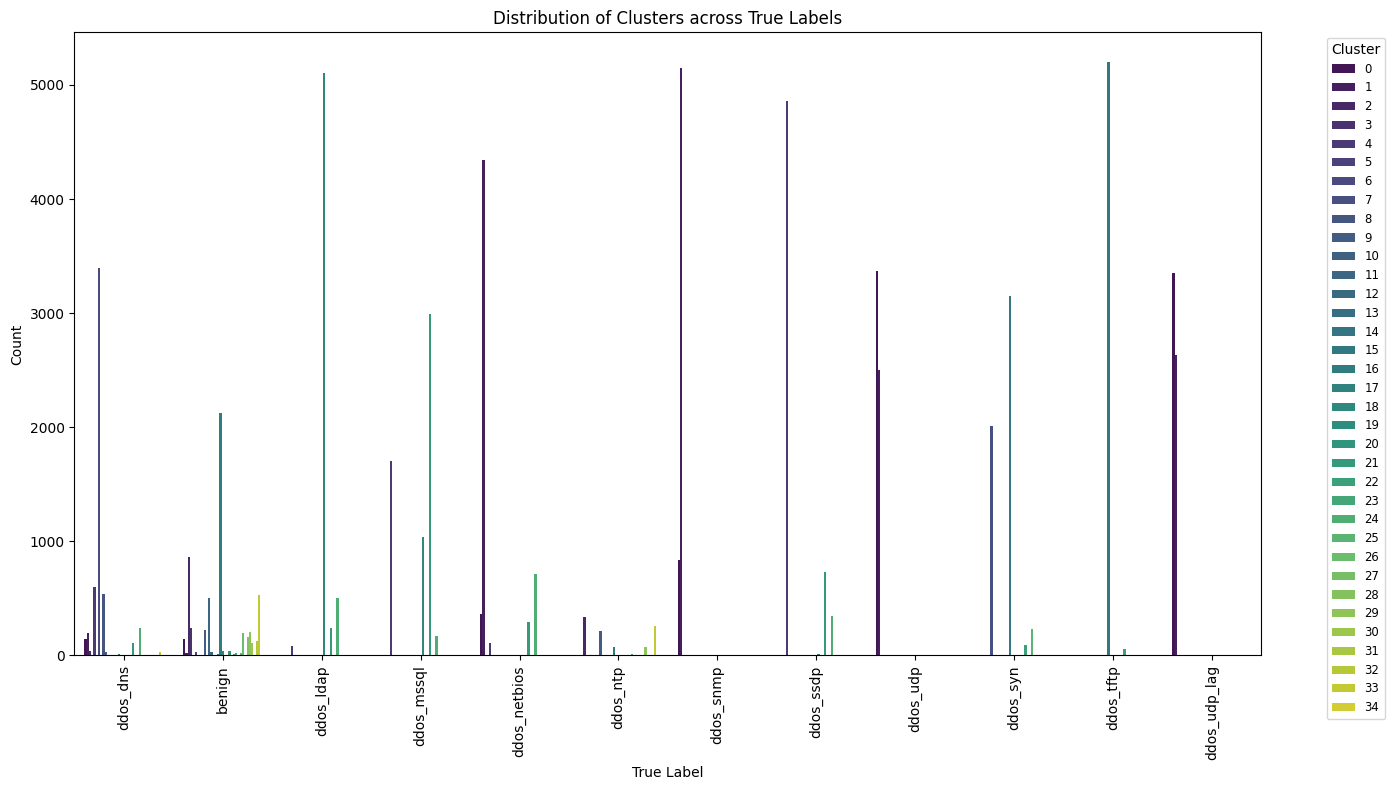

In [39]:
# create a DataFrame to facilitate visualization.
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# distribution of GT label with respect to GT clusters
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Cluster', hue='True Label', palette='viridis')
plt.title('Distribution of True Labels across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()



# distribution of clusters with respect to GT labels
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='True Label', hue='Cluster', palette='viridis')
plt.title('Distribution of Clusters across True Labels')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()




When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


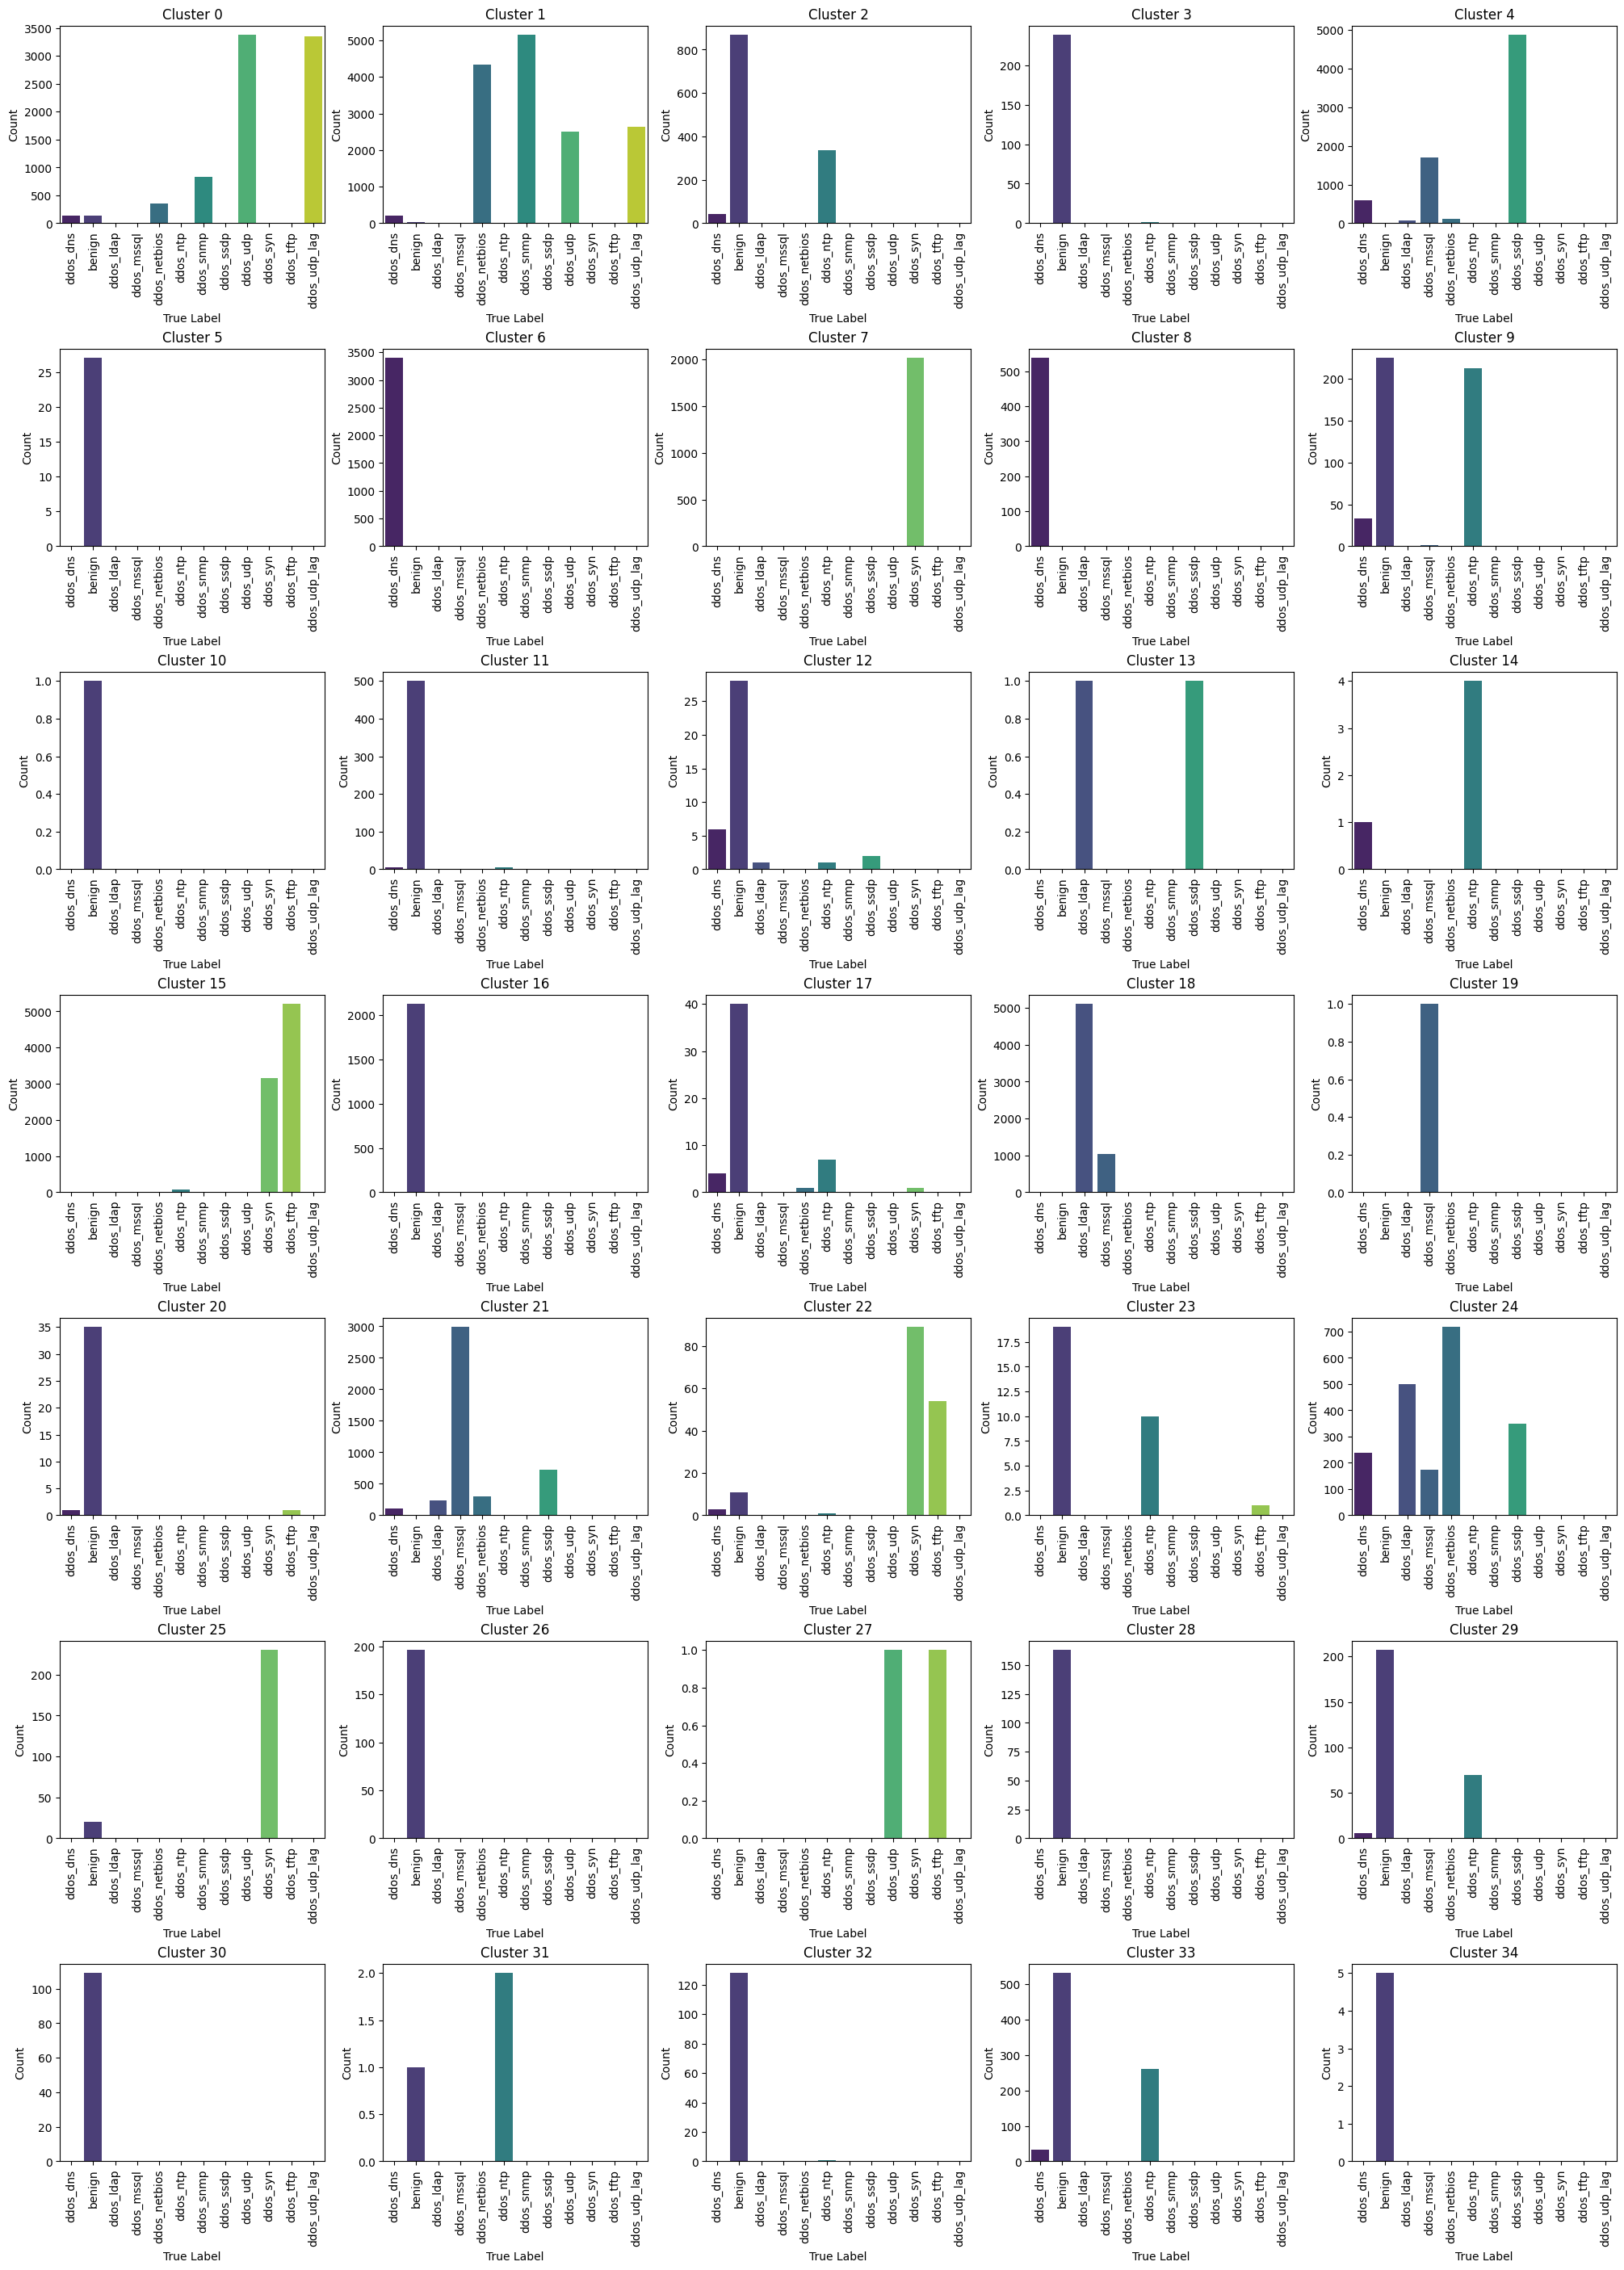

In [40]:
# Create DataFrame with cluster labels and true labels
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# Plot separate boxplots for each cluster in subplots
all_labels = ddos_data_temp['label'].unique()
clusters = sorted(df['Cluster'].unique())

# Calculate the number of rows needed for the subplots
num_clusters = len(clusters)
num_cols = 5
num_rows = (num_clusters + num_cols - 1) // num_cols
num_rows = max(1, num_rows)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()

for idx, cluster in enumerate(clusters):
    cluster_data = df[df['Cluster'] == cluster]
    sns.countplot(x='True Label', data=cluster_data, order=all_labels, palette='viridis', ax=axes[idx])
    axes[idx].set_title(f'Cluster {cluster}')
    axes[idx].set_xlabel('True Label')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=90)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

# Contingency table

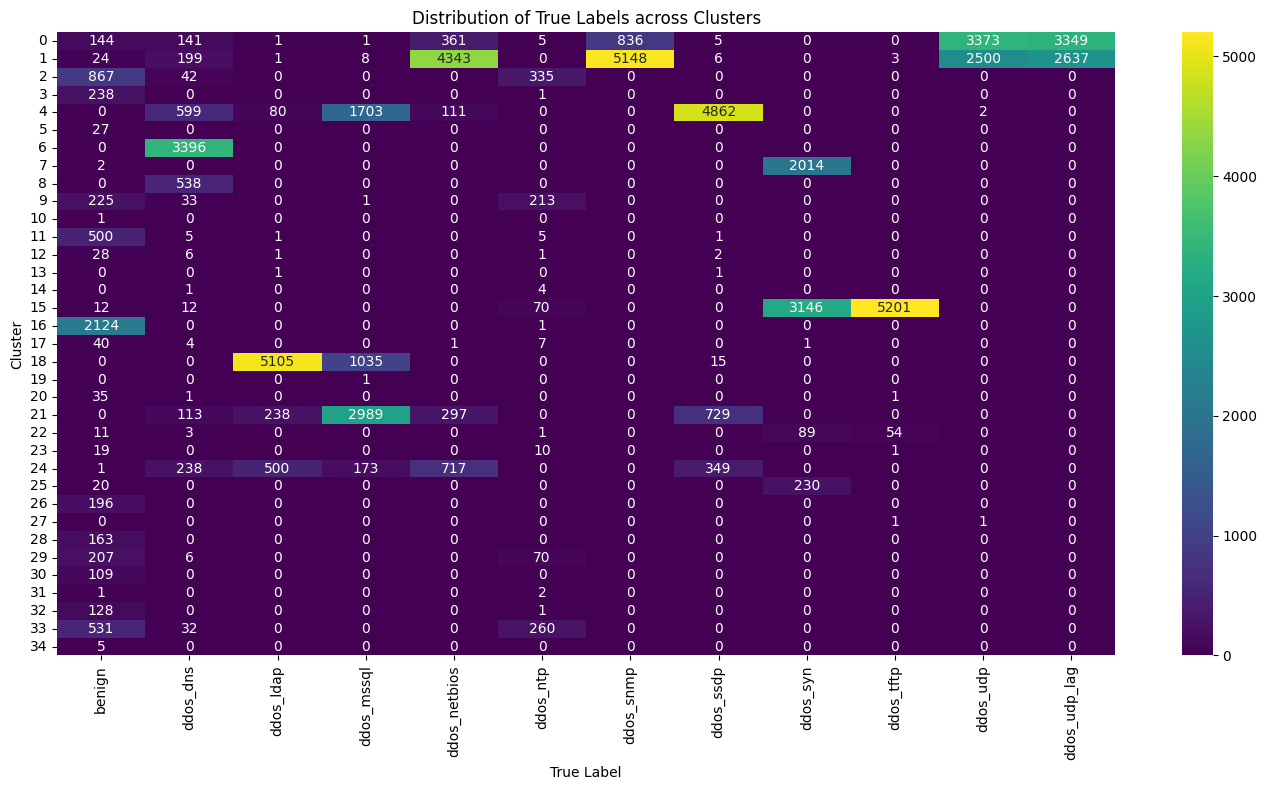

In [41]:
df = pd.DataFrame({'True Label': y.to_numpy().flatten(), 'Cluster': cl_labels})

# Create a contingency table
contingency_table = pd.crosstab(df['Cluster'], df['True Label'])

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="viridis", cbar=True)
plt.title('Distribution of True Labels across Clusters')
plt.xlabel('True Label')
plt.ylabel('Cluster')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Cluster mapping



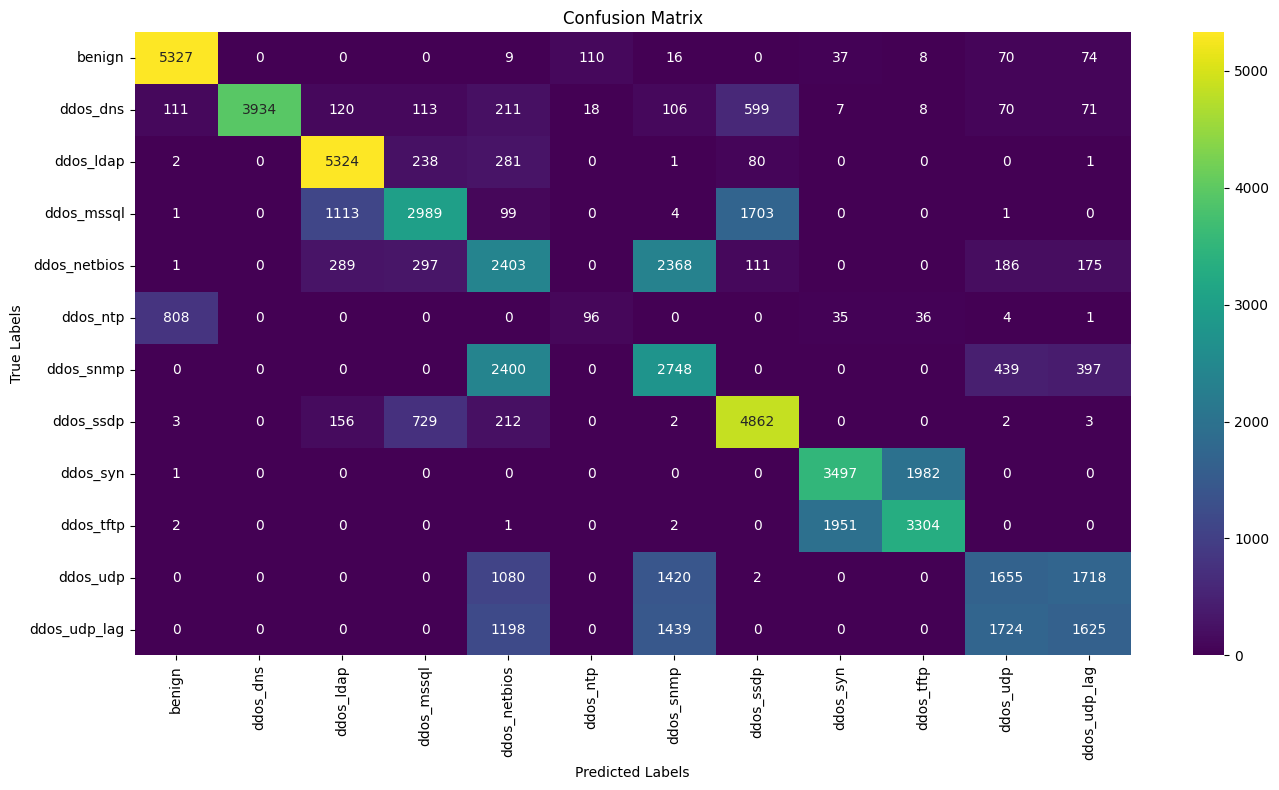

Classification Report:
               precision    recall  f1-score   support

      benign       0.85      0.94      0.89      5651
    ddos_dns       1.00      0.73      0.85      5368
   ddos_ldap       0.76      0.90      0.82      5927
  ddos_mssql       0.68      0.51      0.58      5910
ddos_netbios       0.30      0.41      0.35      5830
    ddos_ntp       0.43      0.10      0.16       980
   ddos_snmp       0.34      0.46      0.39      5984
   ddos_ssdp       0.66      0.81      0.73      5969
    ddos_syn       0.63      0.64      0.64      5480
   ddos_tftp       0.62      0.63      0.62      5260
    ddos_udp       0.40      0.28      0.33      5875
ddos_udp_lag       0.40      0.27      0.32      5986

    accuracy                           0.59     64220
   macro avg       0.59      0.56      0.56     64220
weighted avg       0.60      0.59      0.58     64220

Clusters to Label Mapping with Weights:
Cluster                     Labels with Weights
      0  ddos_udp: 50

In [42]:
y_str = y.to_numpy().flatten()
cl_labels_str = cl_labels.astype(str)

df = pd.DataFrame({'True Label': y_str, 'Cluster': cl_labels_str})

# Identify clusters with a total frequency less than 10 --> Noise
cluster_counts = df['Cluster'].value_counts()
clusters_to_remove = cluster_counts[cluster_counts < 10].index

# Filter the DataFrame to remove these clusters
df = df[~df['Cluster'].isin(clusters_to_remove)]

# Create a contingency table
contingency_table = pd.crosstab(df['Cluster'], df['True Label'])

# Calculate relative frequencies
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Function to assign a label probabilistically based on the filtered weighted distribution
def assign_label_probabilistically(cluster):
    probabilities = relative_frequencies.loc[cluster].values
    labels = relative_frequencies.columns.values
    max_frequency = probabilities.max()

    # Filter labels with at least 60% of the maximum frequency
    filtered_indices = probabilities >= (0.6 * max_frequency)
    filtered_probabilities = probabilities[filtered_indices]
    filtered_labels = labels[filtered_indices]

    # Normalize filtered probabilities to sum to 1
    if filtered_probabilities.sum() > 0:
        filtered_probabilities /= filtered_probabilities.sum()

    return np.random.choice(filtered_labels, p=filtered_probabilities), filtered_labels, filtered_probabilities
#Assign labels probabilistically
predicted_labels = []
cluster_label_weights = []

for cluster in df['Cluster']:
    assigned_label, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    predicted_labels.append(assigned_label)
    cluster_label_weights.append((cluster, list(zip(filtered_labels, filtered_probabilities))))

predicted_labels = np.array(predicted_labels)

# Filter y_str to remove the same clusters
y_filtered = df['True Label'].values

# Confusion matrix
conf_matrix = confusion_matrix(y_filtered, predicted_labels, labels=np.unique(y_str))

plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_str), yticklabels=np.unique(y_str))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_filtered, predicted_labels))

# Create a list to store cluster weights
cluster_label_weights = []

for cluster in np.unique(df['Cluster']):
    _, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    cluster_label_weights.append((cluster, list(zip(filtered_labels, filtered_probabilities))))

# Create a table to display weights in percentage
weights_table_list = []

for cluster, weights in cluster_label_weights:
    weights_str = ', '.join([f"{label}: {weight:.2%}" for label, weight in weights])
    weights_table_list.append({"Cluster": cluster, "Labels with Weights": weights_str})

weights_table = pd.DataFrame(weights_table_list)

# Display the table
print("Clusters to Label Mapping with Weights:")
print(weights_table.to_string(index=False))

# Print the eliminated clusters
print("\nClusters Eliminated (frequency < 10):")
print(clusters_to_remove.tolist())


In [43]:
# Dimensionality reduction with t-SNE.
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_s)

In [44]:
# Prediction of cluster including noise, for t-SNE compatibility reason
df = pd.DataFrame({'True Label': y_str, 'Cluster': cl_labels_str})
contingency_table = pd.crosstab(df['Cluster'], df['True Label'])
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0)
predicted_labels_noise = []
for cluster in df['Cluster']:
    assigned_label, filtered_labels, filtered_probabilities = assign_label_probabilistically(cluster)
    predicted_labels_noise.append(assigned_label)
predicted_labels_noise = np.array(predicted_labels_noise)

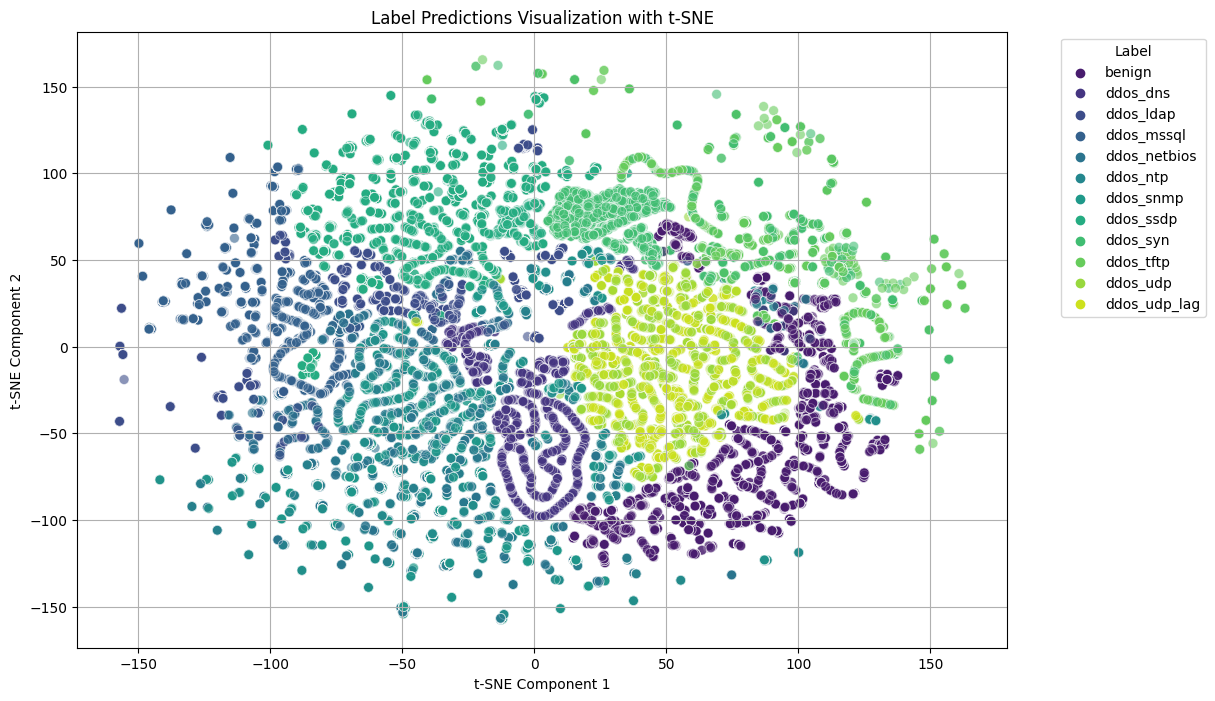

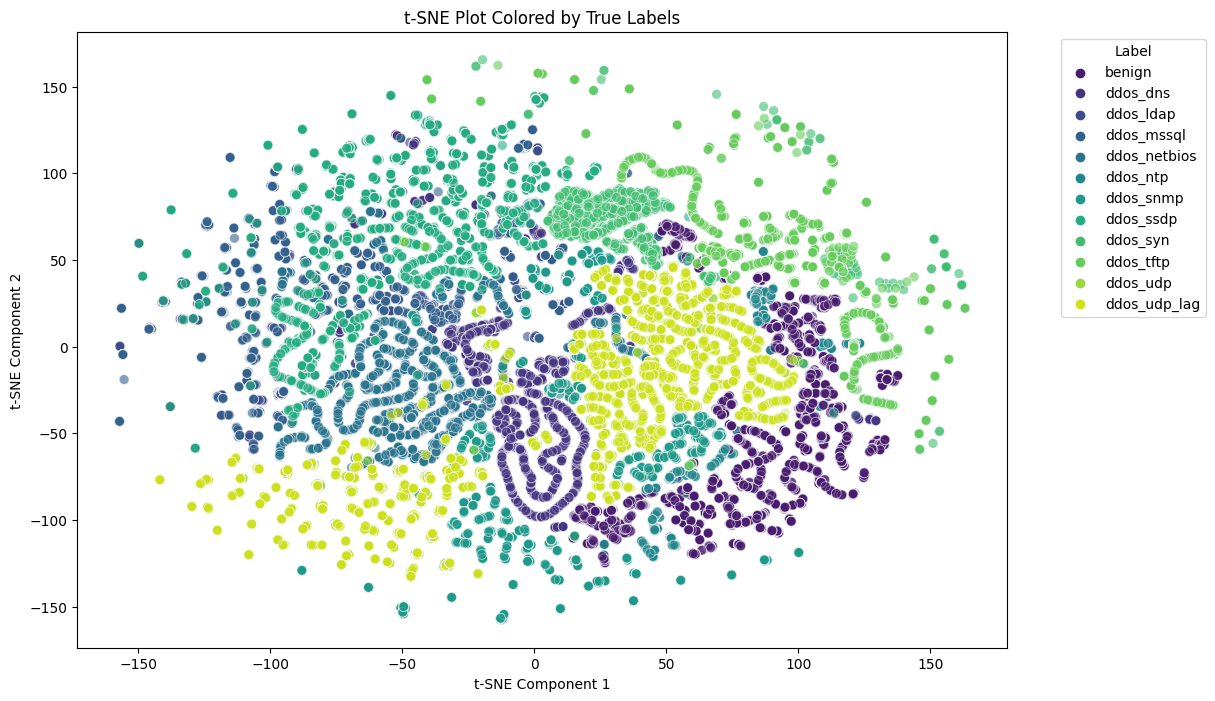

In [45]:
# Creating a distinctive color palette.
unique_labels = np.unique(np.concatenate((predicted_labels_noise, y.to_numpy().flatten())))
palette = sns.color_palette("viridis", len(unique_labels))
color_mapping = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to map labels to colors.
def map_colors(labels, color_mapping):
    return [color_mapping[label] for label in labels]

# Plot of clusters in the reduced space using t-SNE.
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predicted_labels_noise, palette=color_mapping, s=50, alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = scatter.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: labels[k])
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Label', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Label Predictions Visualization with t-SNE')
plt.grid(True)
plt.show()

# Plot t-SNE colored by the real labels.
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y.to_numpy().flatten(), palette=color_mapping, s=50, alpha=0.6)
plt.title('t-SNE Plot Colored by True Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = scatter.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: labels[k])
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ECDF of number of clusters assigned to each label

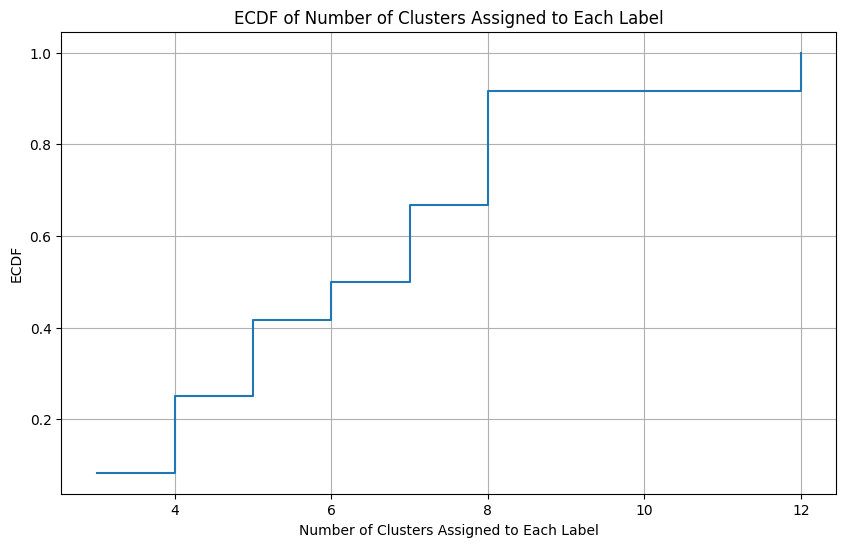

Number of Clusters Assigned to Each Label:
True Label
benign           8
ddos_dns        12
ddos_ldap        7
ddos_mssql       7
ddos_netbios     8
ddos_ntp         6
ddos_snmp        4
ddos_ssdp        8
ddos_syn         3
ddos_tftp        5
ddos_udp         5
ddos_udp_lag     4
Name: Predicted Label, dtype: int64


In [46]:
df_results = pd.DataFrame({'True Label': y_filtered, 'Predicted Label': predicted_labels})

# Count the number of clusters assigned to each label
cluster_counts_per_label = df_results.groupby('True Label')['Predicted Label'].nunique()
sorted_counts = np.sort(cluster_counts_per_label.values)

# ECDF
ecdf_y = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

plt.figure(figsize=(10, 6))
plt.step(sorted_counts, ecdf_y, where='post')
plt.xlabel('Number of Clusters Assigned to Each Label')
plt.ylabel('ECDF')
plt.title('ECDF of Number of Clusters Assigned to Each Label')
plt.grid(True)
plt.show()

print("Number of Clusters Assigned to Each Label:")
print(cluster_counts_per_label)

# Featues importance

## KMeans Interp

[Errno 2] No such file or directory: 'kmeans-feature-importance # Navigate into the cloned repository'
/kaggle/working/kmeans-feature-importance


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Le 10 caratteristiche più importanti per il cluster 0 sono: [('Fwd Packets/s', 1.1164635077461726), ('Flow Bytes/s', 0.7584848741662813), ('ACK Flag Count', 0.4850712500726263), ('Source Port Freq', 0.43723380721932253), ('Fwd Packet Length Max', 0.41902553838160506), ('Max Packet Length', 0.307469222726581), ('Destination Port Freq', 0.28306395677301777), ('Fwd Packet Length Std', 0.26794985309951647), ('Down/Up Ratio', 0.2647609348787702), ('Inbound', 0.2608446469223043)]
Le 10 caratteristiche più importanti per il cluster 1 sono: [('Fwd Packets/s', 0.9055308077641276), ('ACK Flag Count', 0.48507125007265867), ('Fwd Packet Length Max', 0.4168310504119475), ('Source Port Freq', 0.4047490541592124), ('Max Packet Length', 0.30606706139364687), ('Destination Port Freq', 0.28601026443398897), ('Init_Win_bytes_forward', 0.26626110116083695), ('Down/Up Ratio', 0.2655231662226614), ('act_data_pkt_fwd', 0.26548162956752025), ('Inbound', 0.2606372674651779)]
Le 10 caratteristiche più important

Cluster                Feature  Importance
0          0          Fwd Packets/s    1.116464
1          0           Flow Bytes/s    0.758485
2          0         ACK Flag Count    0.485071
3          0       Source Port Freq    0.437234
4          0  Fwd Packet Length Max    0.419026
..       ...                    ...         ...
345       34                Inbound    3.381206
346       34  Destination Port Freq    2.512911
347       34      Max Packet Length    2.462880
348       34          Fwd Packets/s    1.151295
349       34  Fwd Packet Length Max    1.048329

[350 rows x 3 columns]

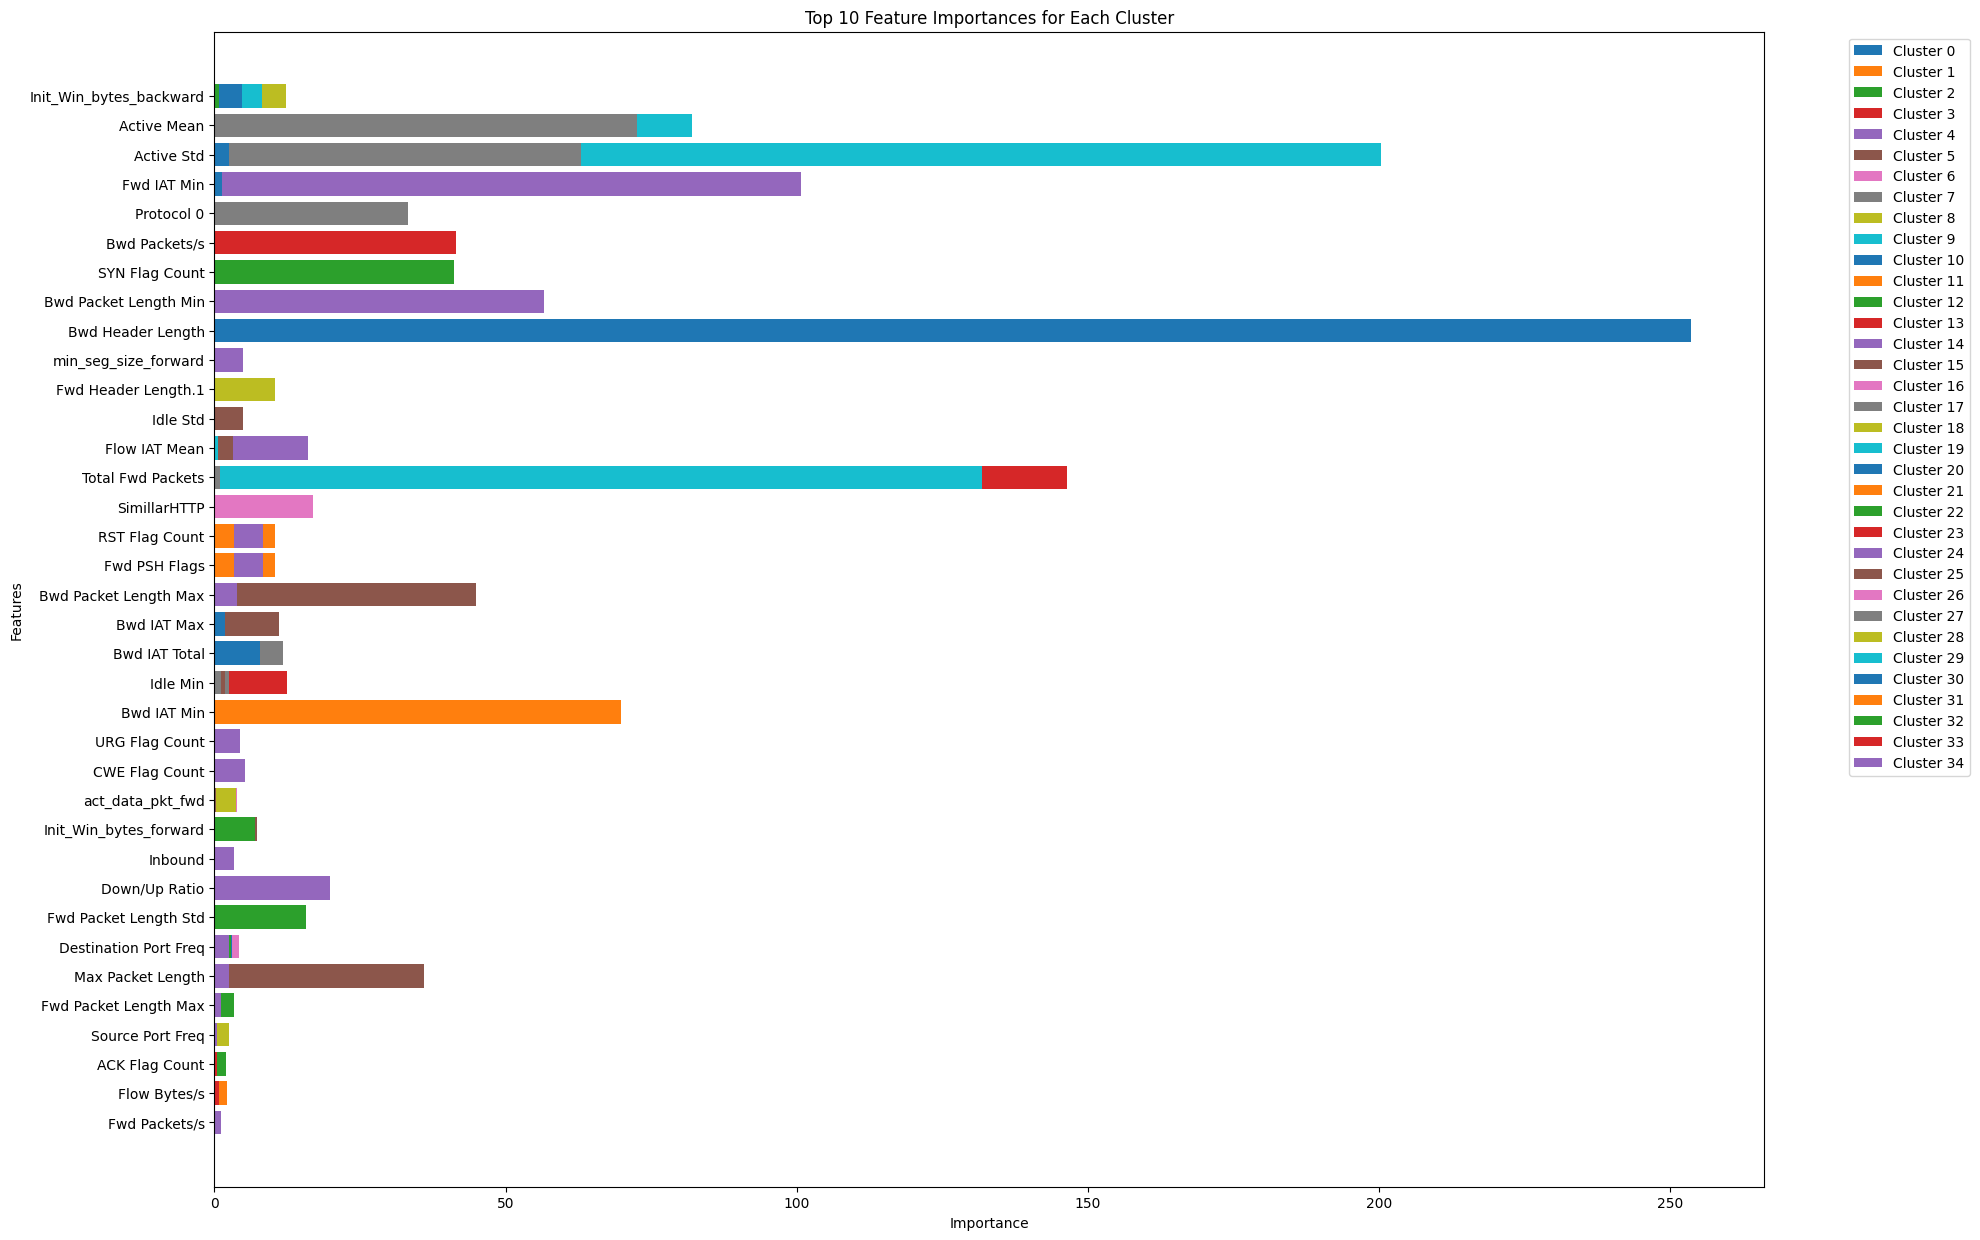

/kaggle/working


In [31]:
#!git clone https://github.com/YousefGh/kmeans-feature-importance.git

%cd kmeans-feature-importance # Navigate into the cloned repository

from kmeans_interp.kmeans_feature_imp import KMeansInterp

#just add random_state

# Apply k-means clustering and calculate feature importance
kms = KMeansInterp(
    n_clusters=35,  # Number of cluster
    random_state=0,
    ordered_feature_names=ddos_data.drop(columns=['label']).columns.tolist(),
    feature_importance_method='wcss_min'  # o 'unsup2sup'
).fit(X_s)


importance_data = []

# Get the feature importance for cluster 0 and display the first 10 important features
for i in range(35):
  important_features_cluster= kms.feature_importances_[i][:10]
  print(f"Le 10 caratteristiche più importanti per il cluster {i} sono:", important_features_cluster)
  for feature, importance in important_features_cluster:
    importance_data.append({'Cluster': i, 'Feature': feature, 'Importance': importance})

importance_df = pd.DataFrame(importance_data)

# Display the DataFrame
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(20, 15))

for cluster in range(35):
    cluster_data = importance_df[importance_df['Cluster'] == cluster]
    plt.barh(cluster_data['Feature'], cluster_data['Importance'], label=f'Cluster {cluster}')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances for Each Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
%cd ..

In [35]:
#!pip install tabulate
from tabulate import tabulate

# Group by cluster and display top features
grouped_df = importance_df.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Importance')).reset_index(drop=True)

# Print the grouped DataFrame using tabulate
print("Top 5 Feature Importances for Each Cluster:")
for cluster in grouped_df['Cluster'].unique():
    cluster_data = grouped_df[grouped_df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(tabulate(cluster_data[['Feature', 'Importance']], headers='keys', tablefmt='fancy_grid'))

Top 5 Feature Importances for Each Cluster:

Cluster 0:
╒════╤═══════════════════════╤══════════════╕
│    │ Feature               │   Importance │
╞════╪═══════════════════════╪══════════════╡
│  0 │ Fwd Packets/s         │     1.11646  │
├────┼───────────────────────┼──────────────┤
│  1 │ Flow Bytes/s          │     0.758485 │
├────┼───────────────────────┼──────────────┤
│  2 │ ACK Flag Count        │     0.485071 │
├────┼───────────────────────┼──────────────┤
│  3 │ Source Port Freq      │     0.437234 │
├────┼───────────────────────┼──────────────┤
│  4 │ Fwd Packet Length Max │     0.419026 │
╘════╧═══════════════════════╧══════════════╛

Cluster 1:
╒════╤═══════════════════════╤══════════════╕
│    │ Feature               │   Importance │
╞════╪═══════════════════════╪══════════════╡
│  5 │ Fwd Packets/s         │     0.905531 │
├────┼───────────────────────┼──────────────┤
│  6 │ ACK Flag Count        │     0.485071 │
├────┼───────────────────────┼──────────────┤
│  7 │ Fwd P

/tmp/ipykernel_395/3686564158.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = importance_df.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Importance')).reset_index(drop=True)


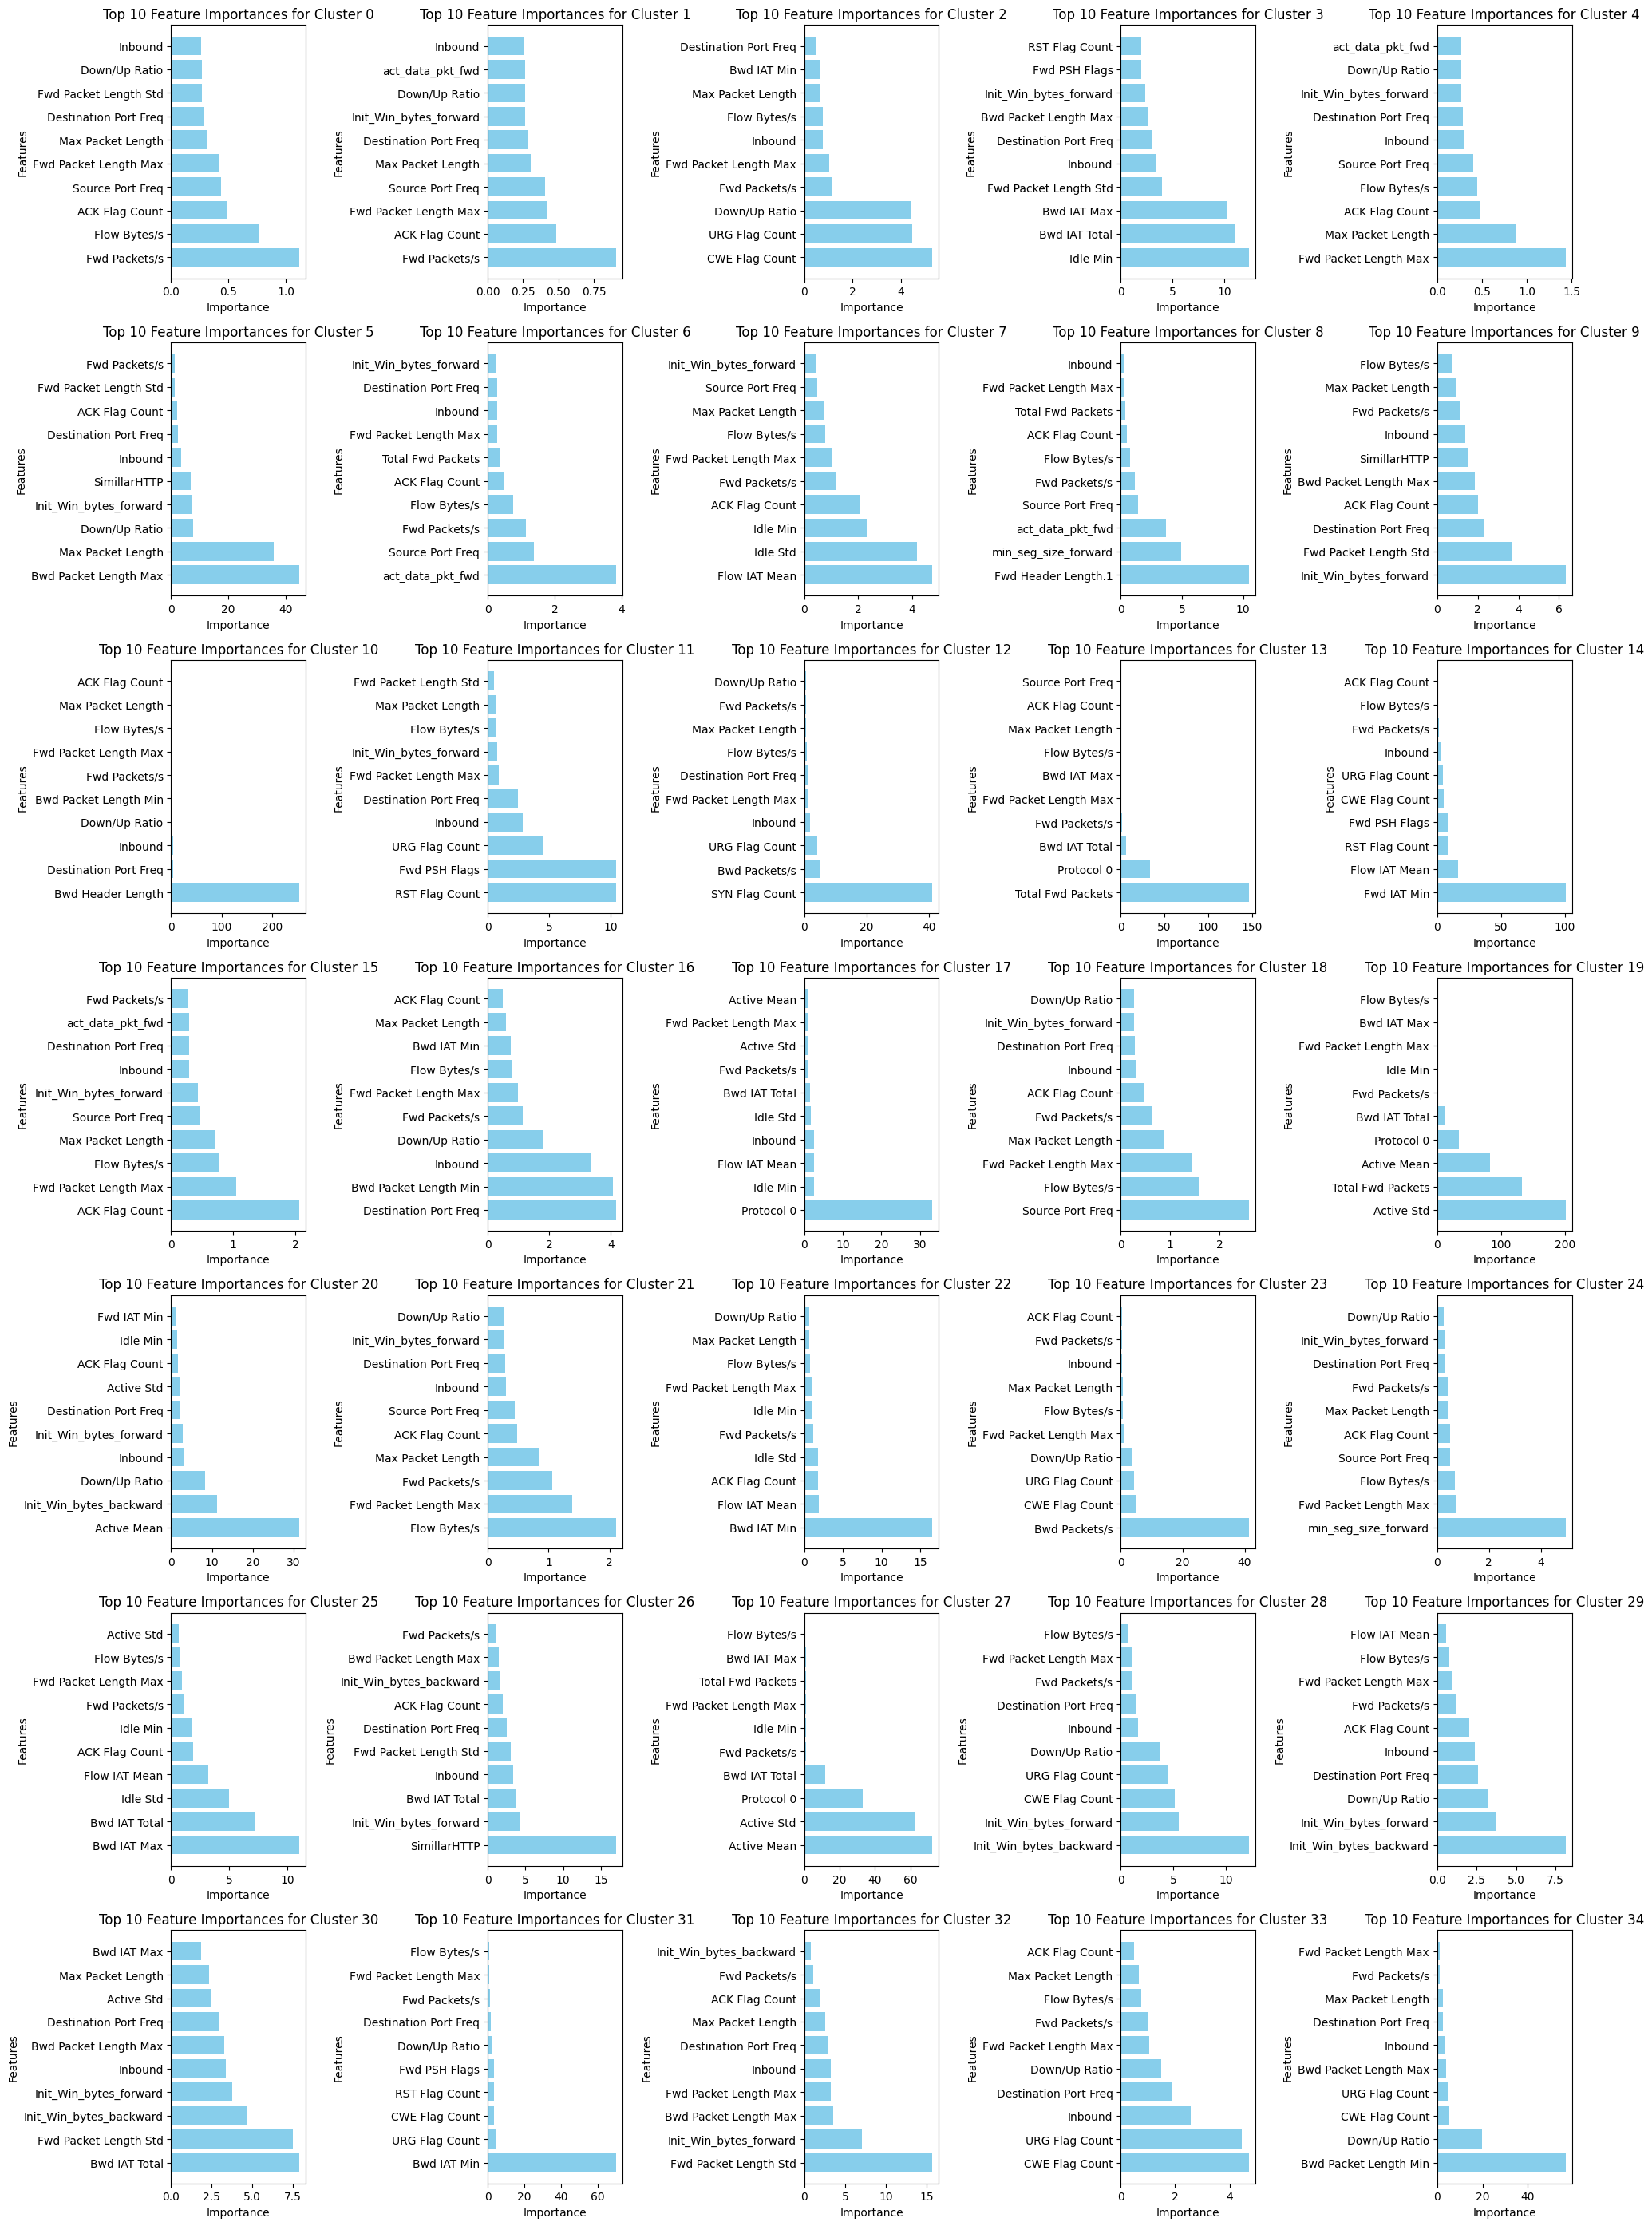

In [36]:
# Create subplots
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 28))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

# Plot the feature importances for each cluster separately for better clarity
for idx, cluster in enumerate(range(35)):
    cluster_data = importance_df[importance_df['Cluster'] == cluster]
    axes[idx].barh(cluster_data['Feature'], cluster_data['Importance'], color='skyblue')
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('Features')
    axes[idx].set_title(f'Top 10 Feature Importances for Cluster {cluster}')
plt.tight_layout()
plt.show()


## Shap


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Cluster 0


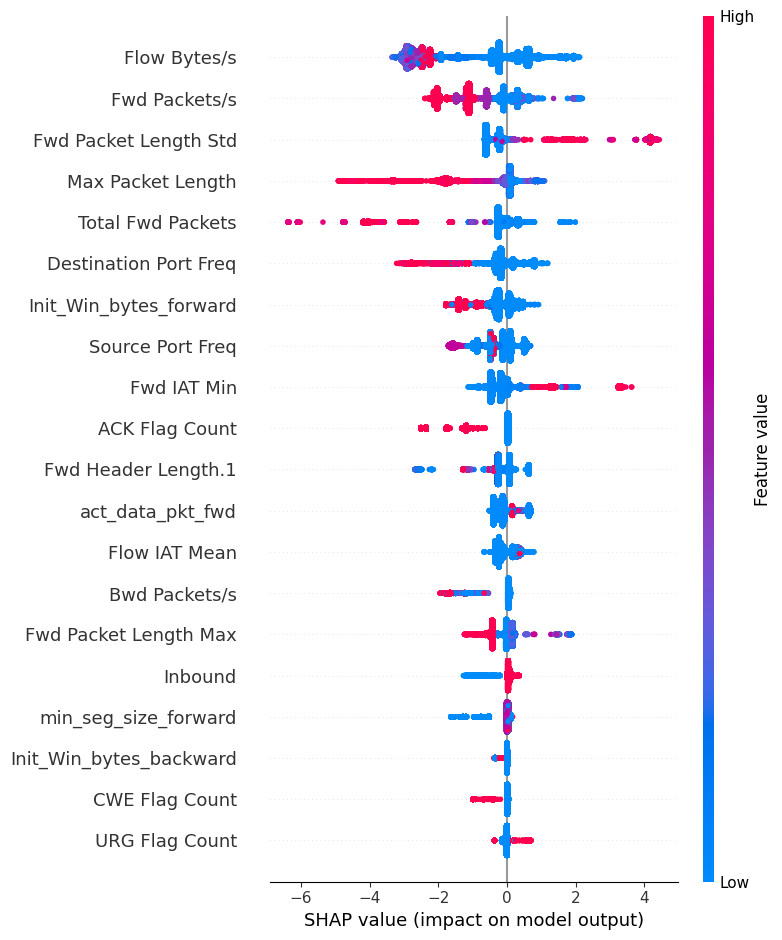

Cluster 1


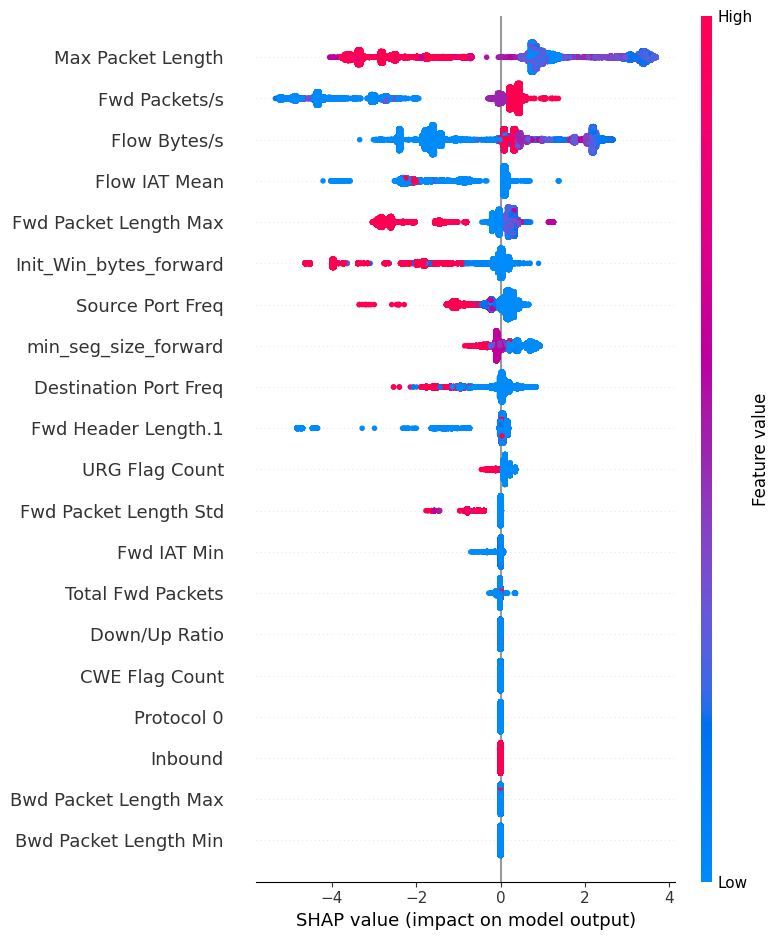

Cluster 2


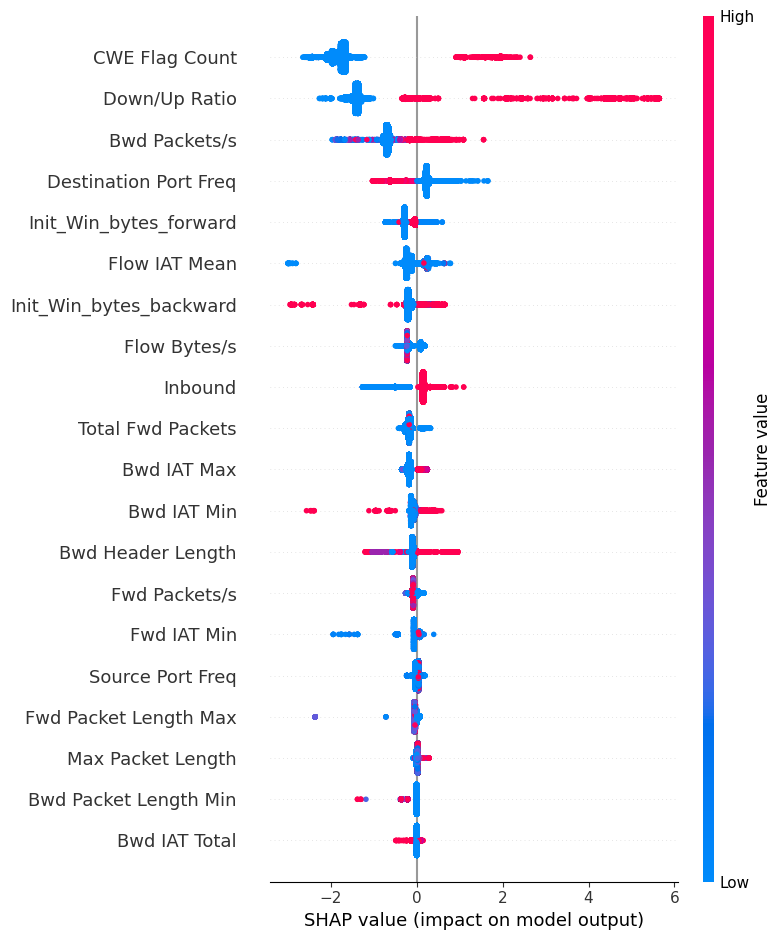

Cluster 3


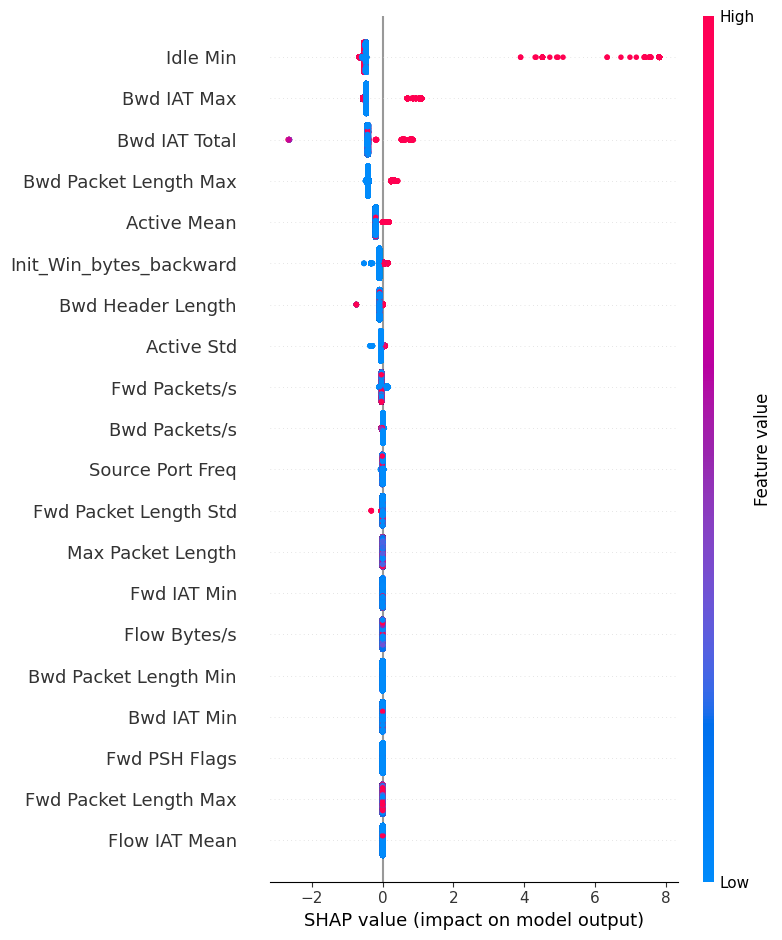

Cluster 4


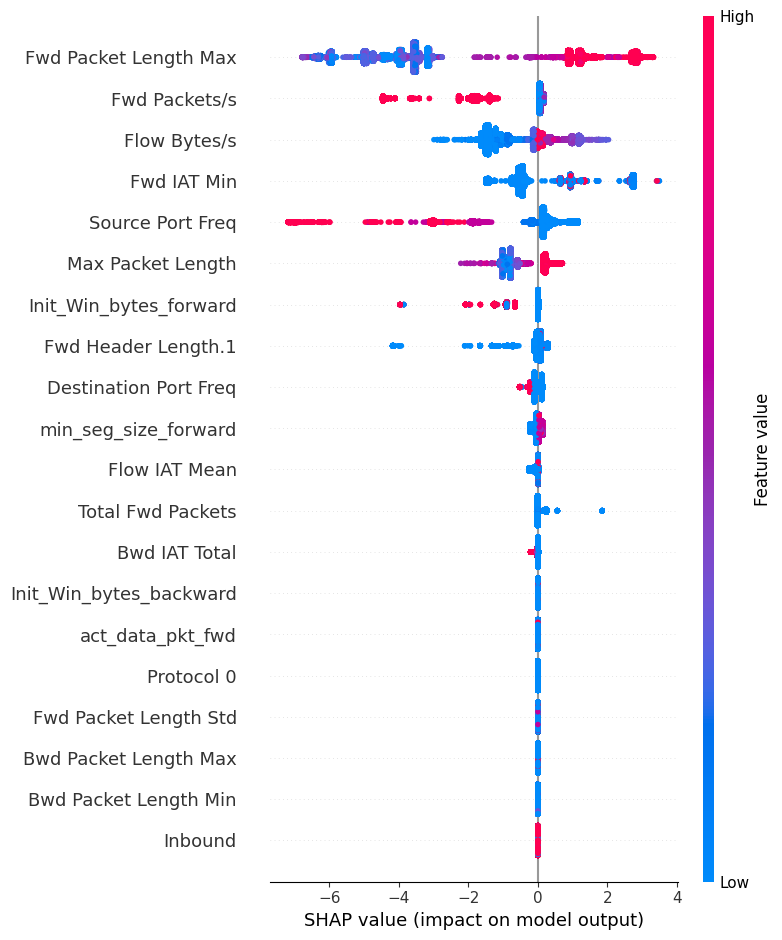

Cluster 5


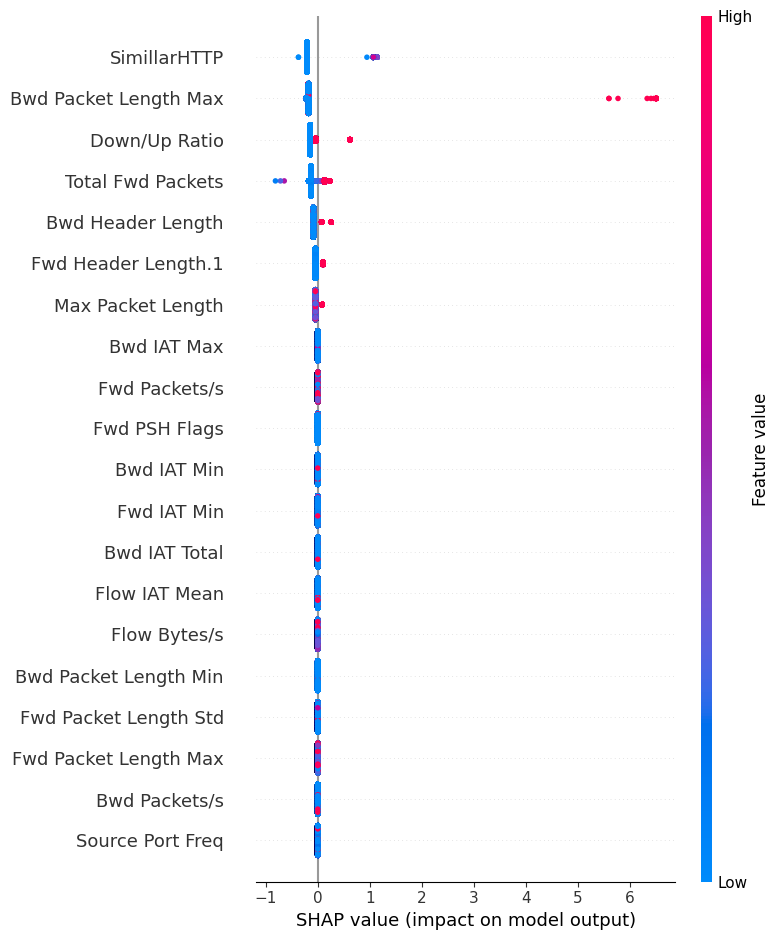

Cluster 6


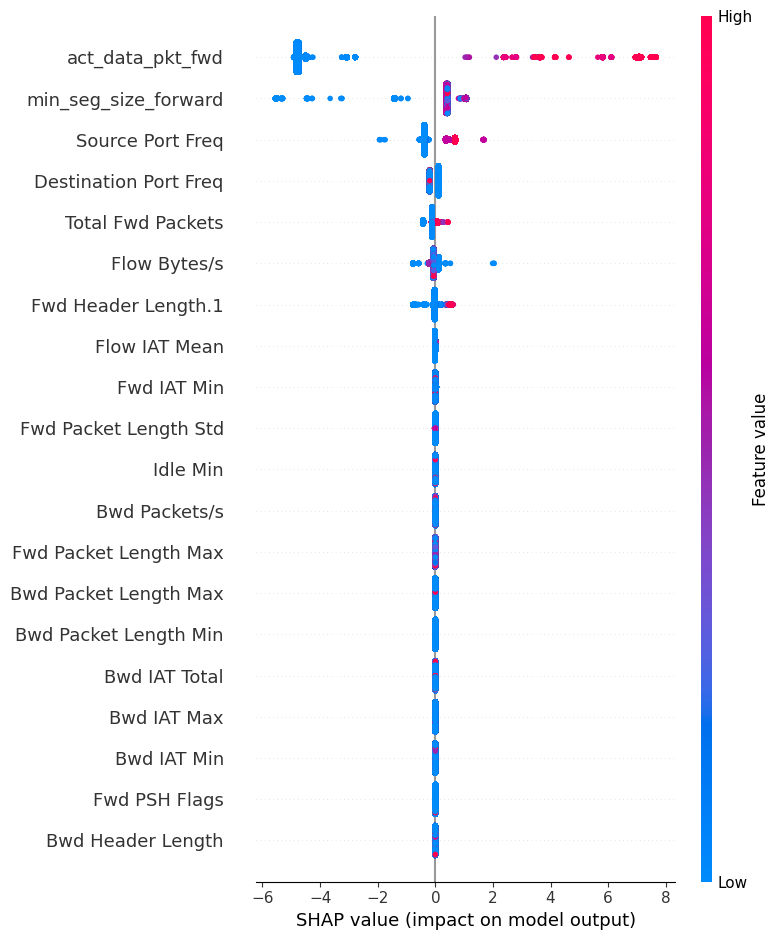

Cluster 7


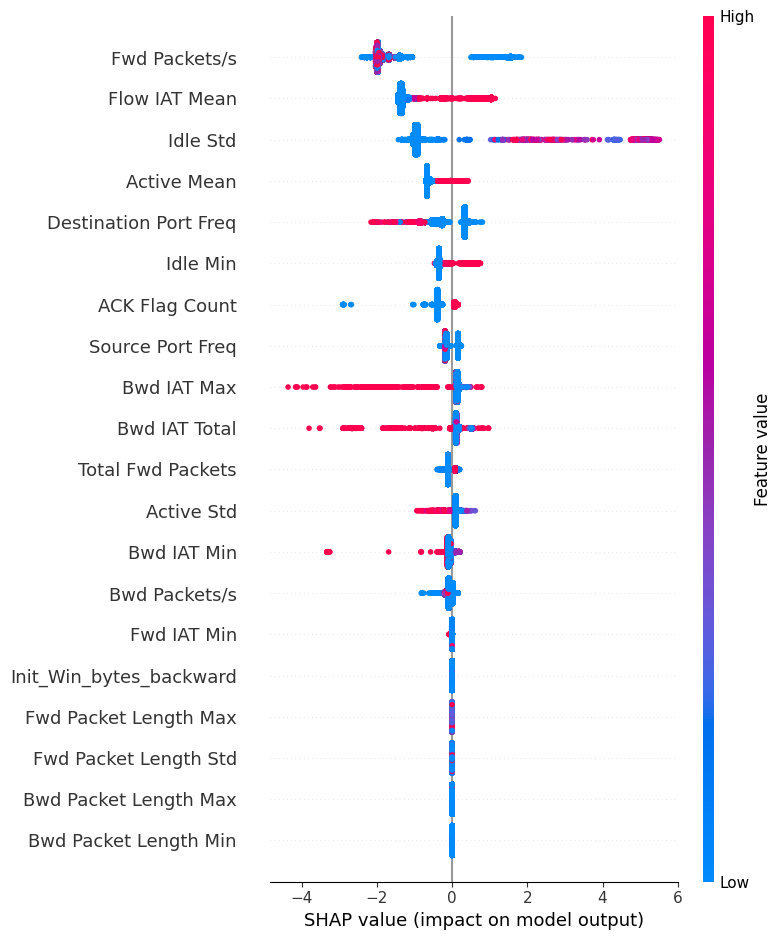

Cluster 8


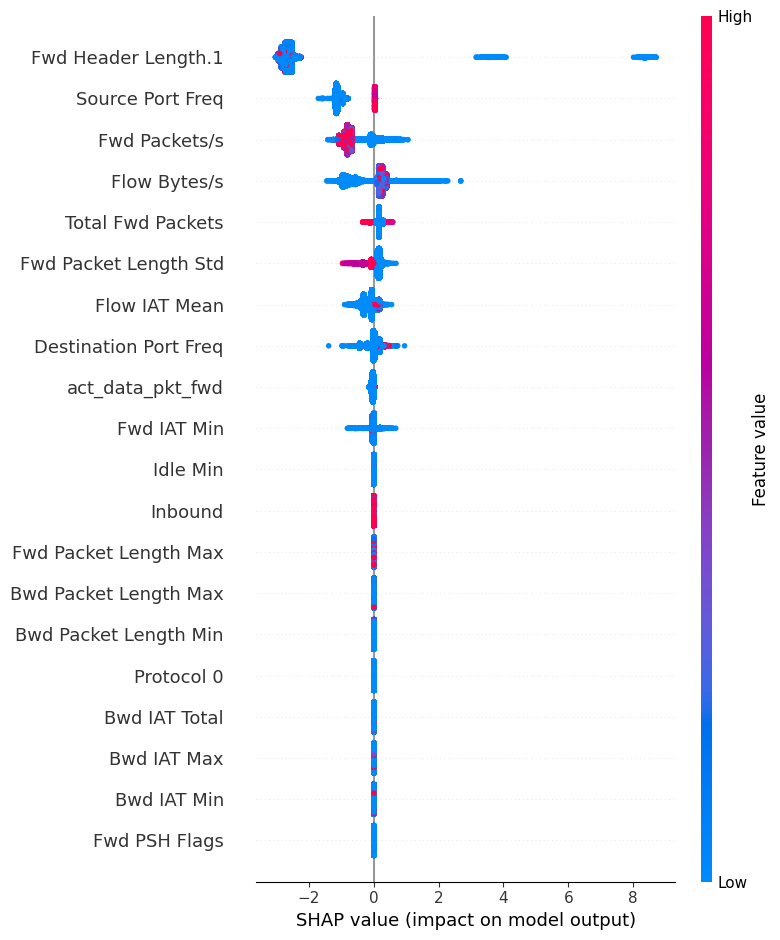

Cluster 9


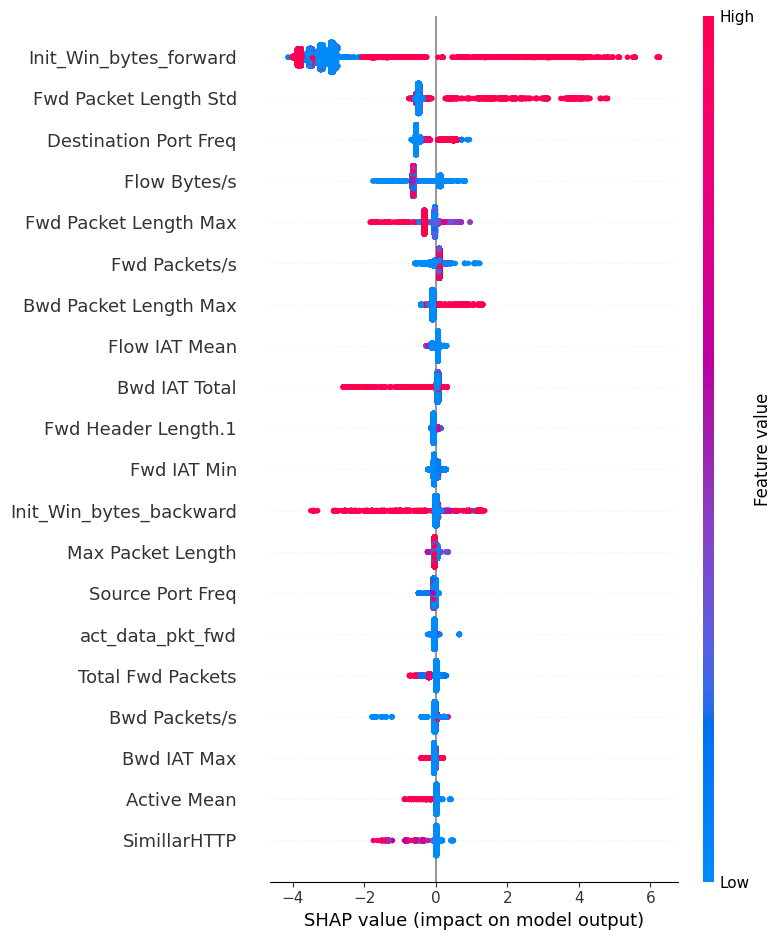

Cluster 10


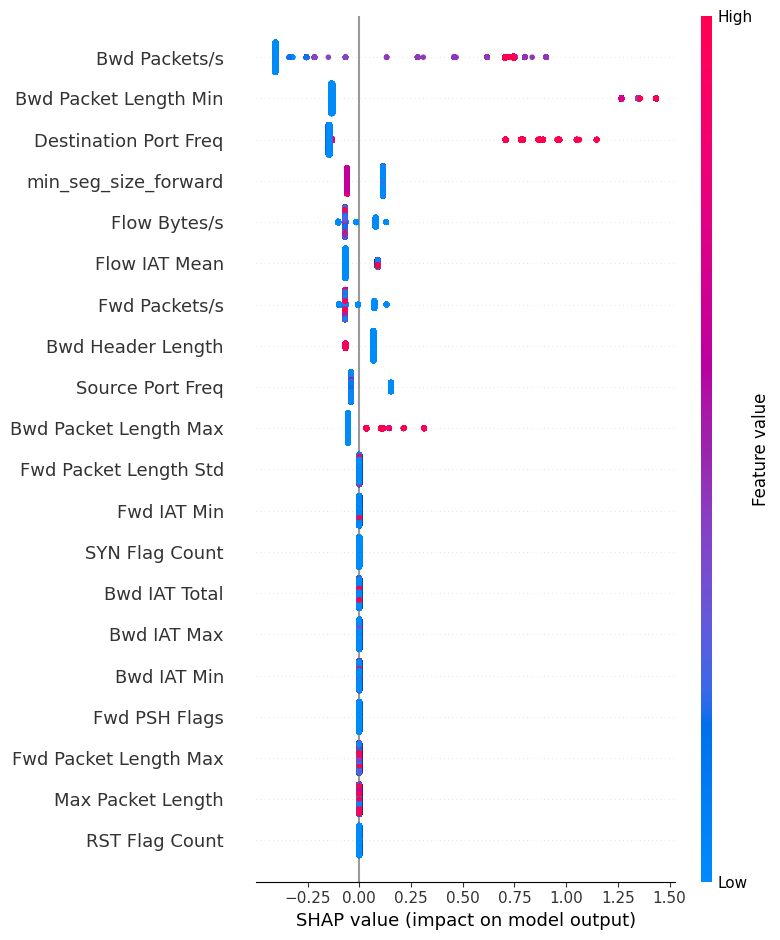

Cluster 11


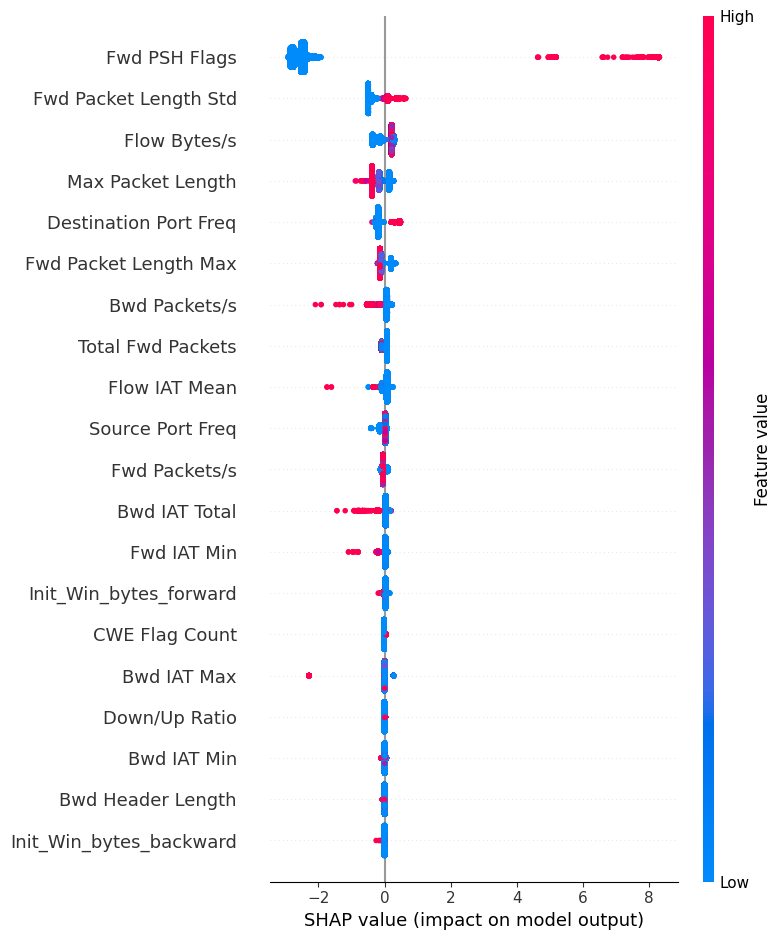

Cluster 12


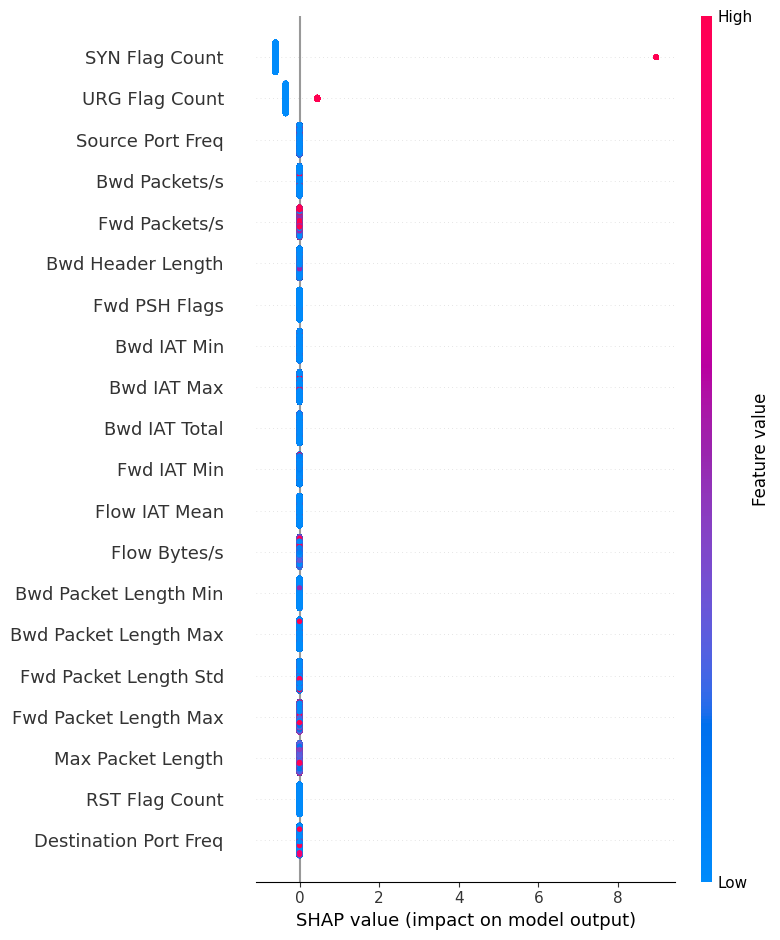

Cluster 13


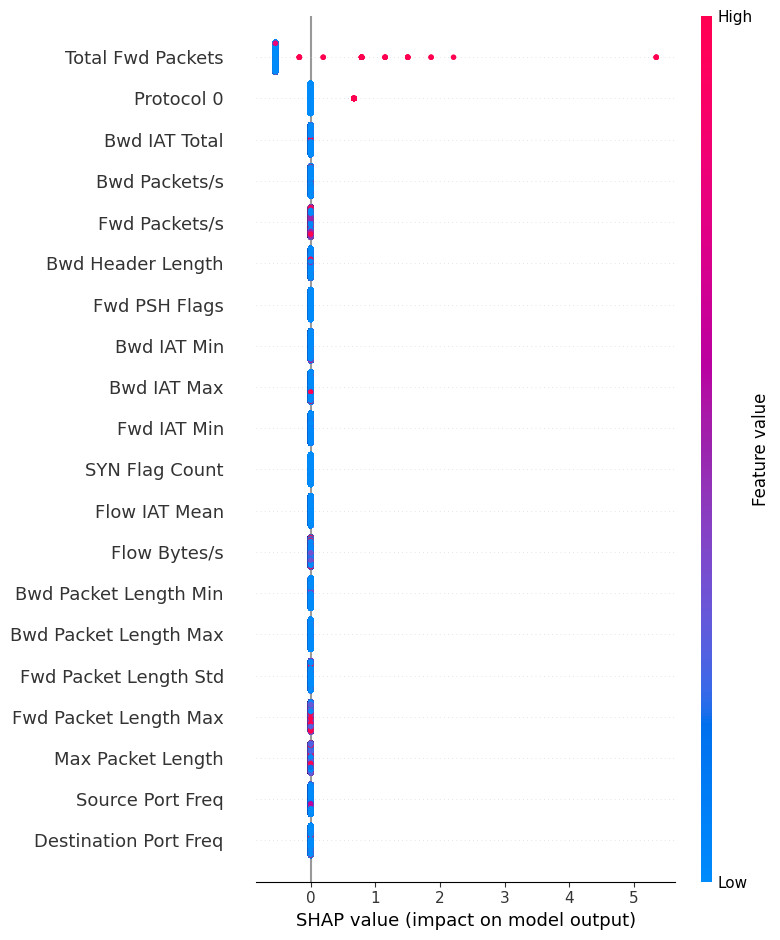

Cluster 14


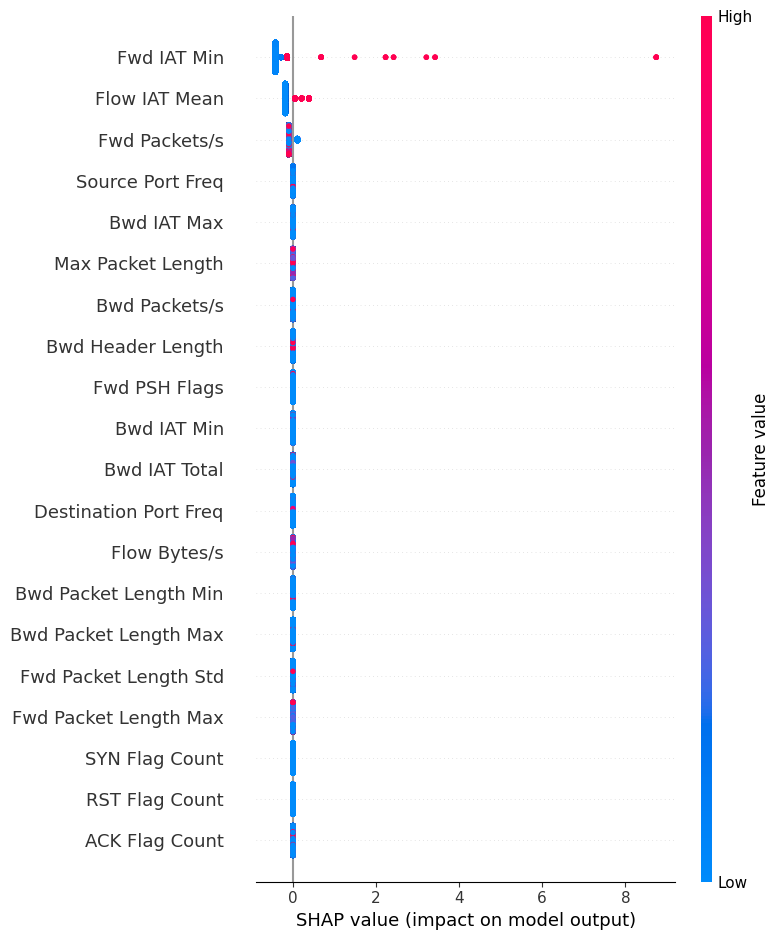

Cluster 15


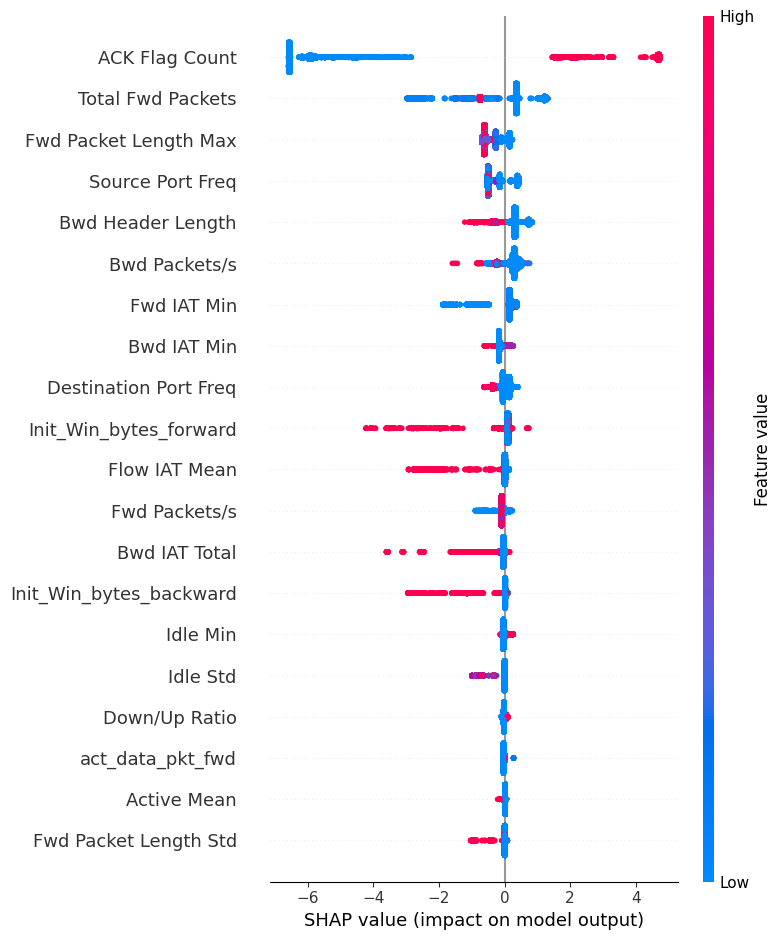

Cluster 16


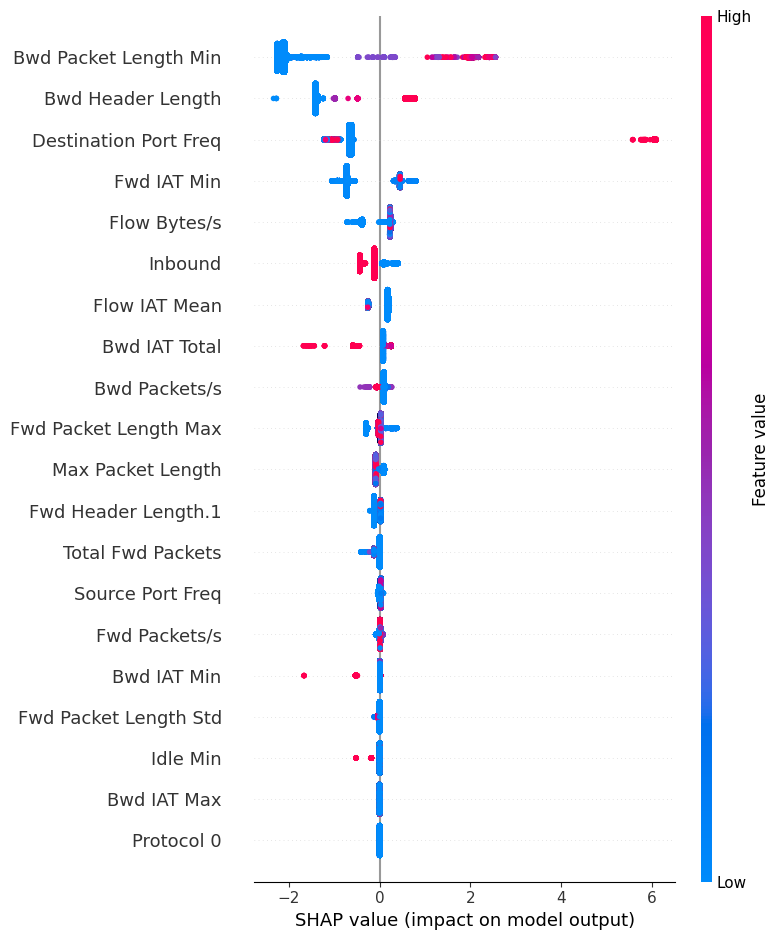

Cluster 17


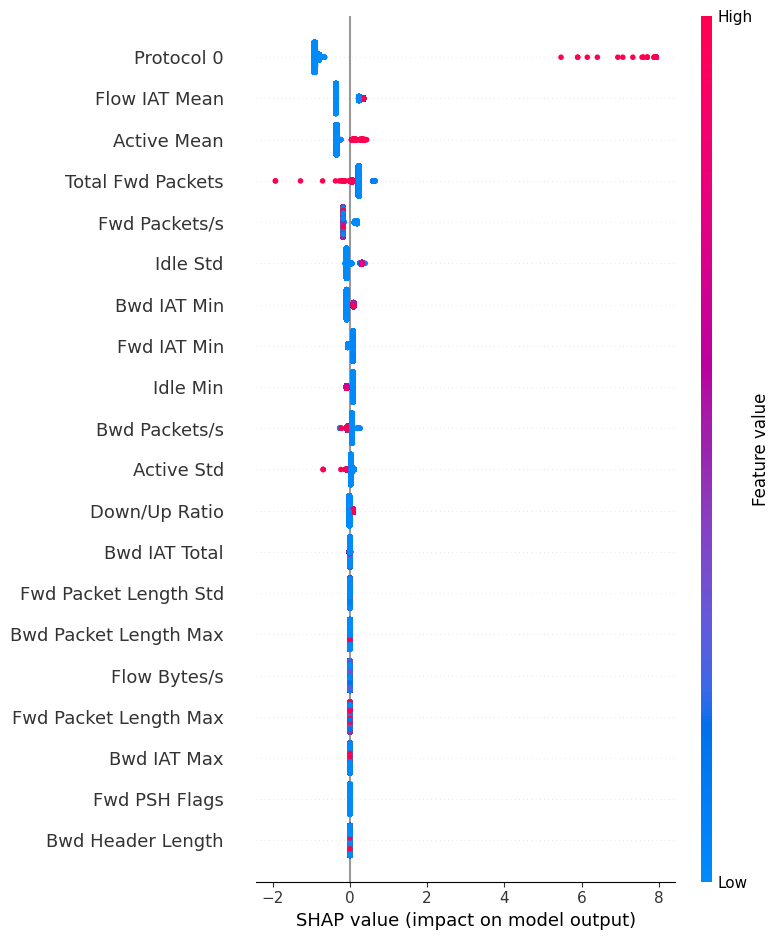

Cluster 18


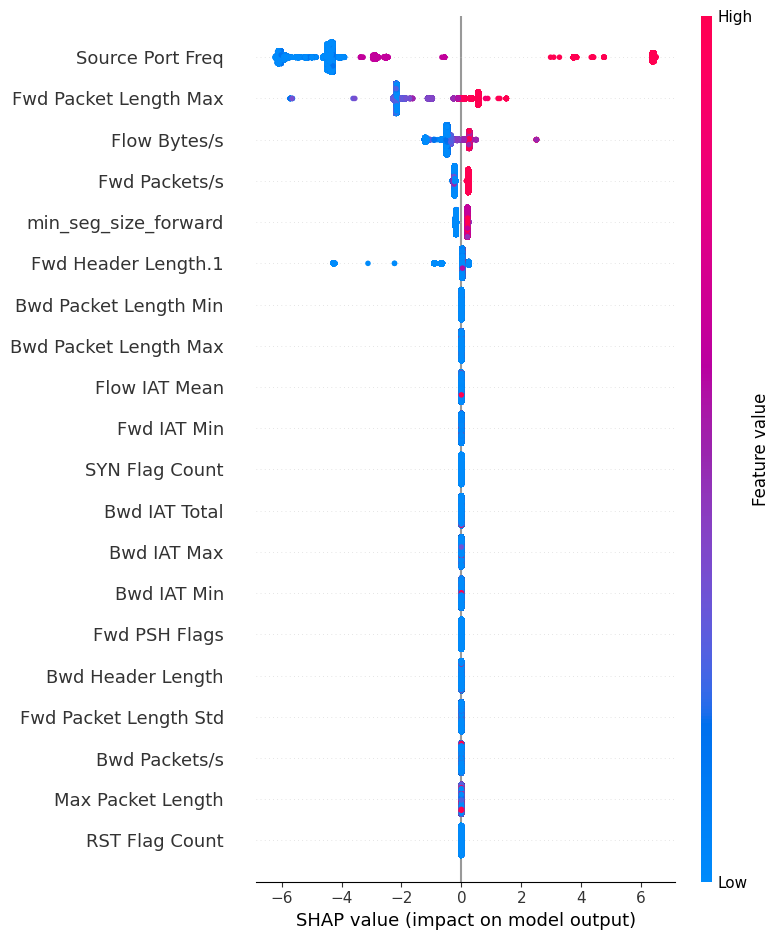

Cluster 19


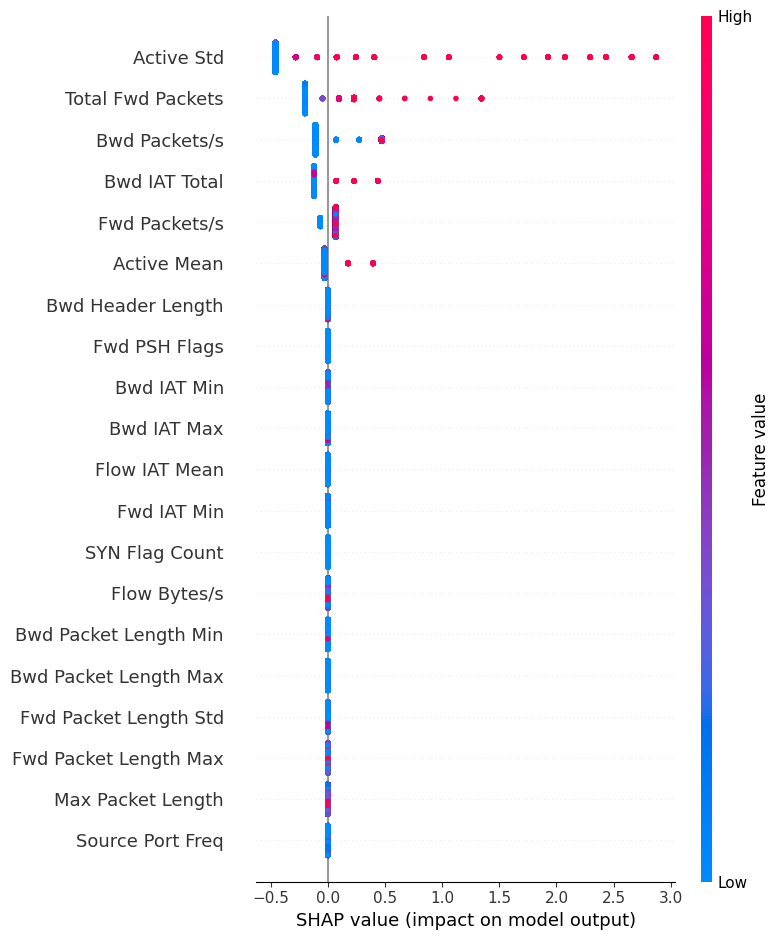

Cluster 20


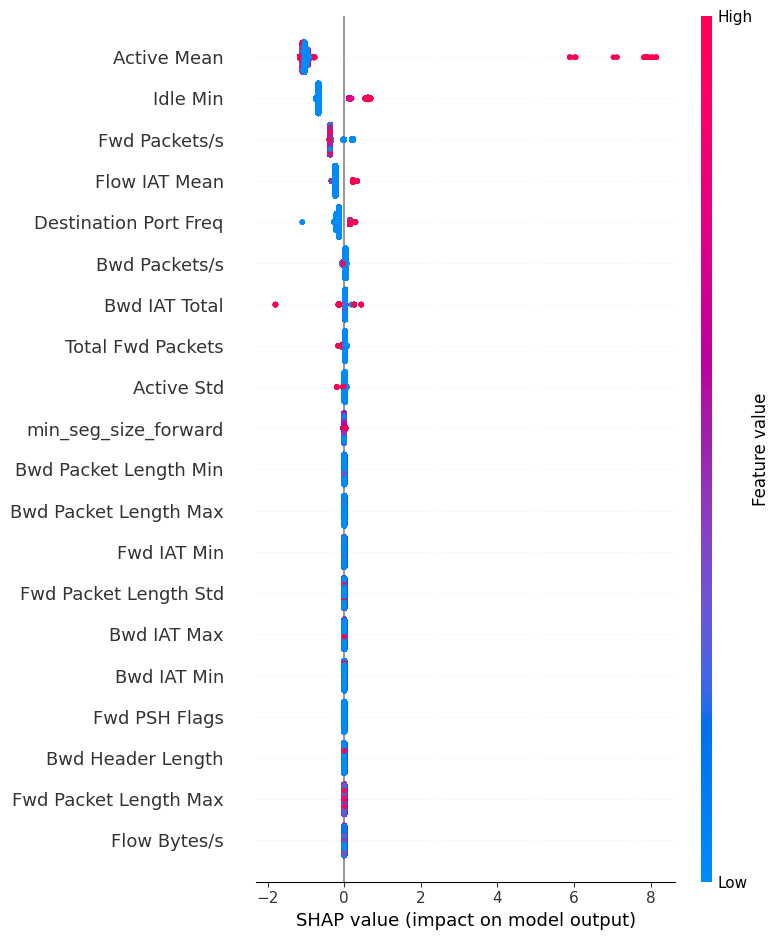

Cluster 21


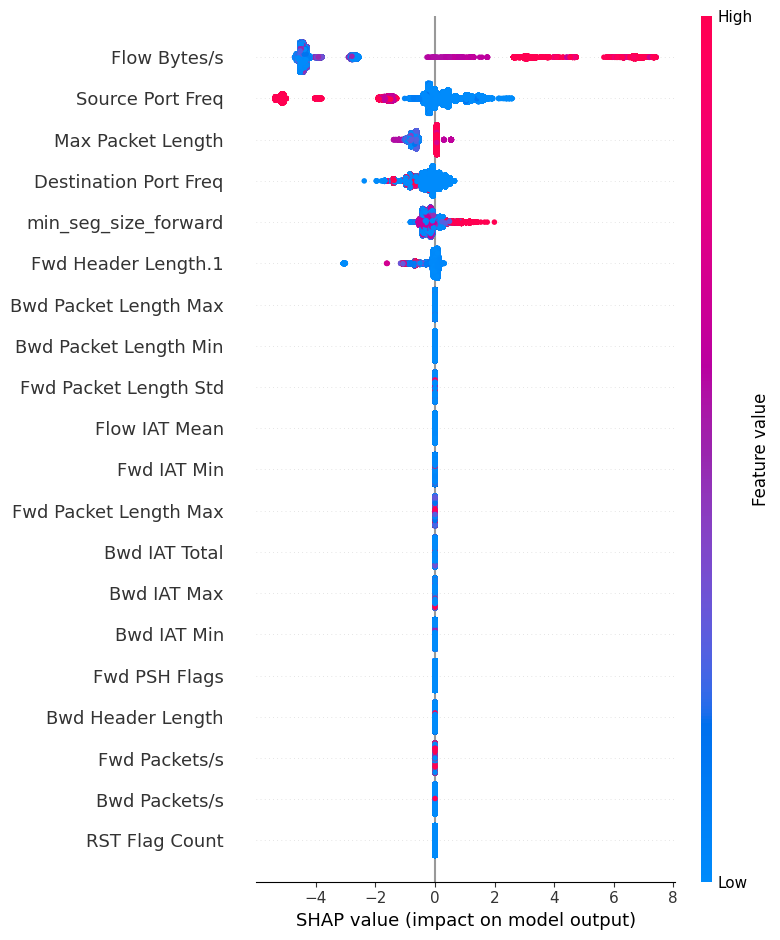

Cluster 22


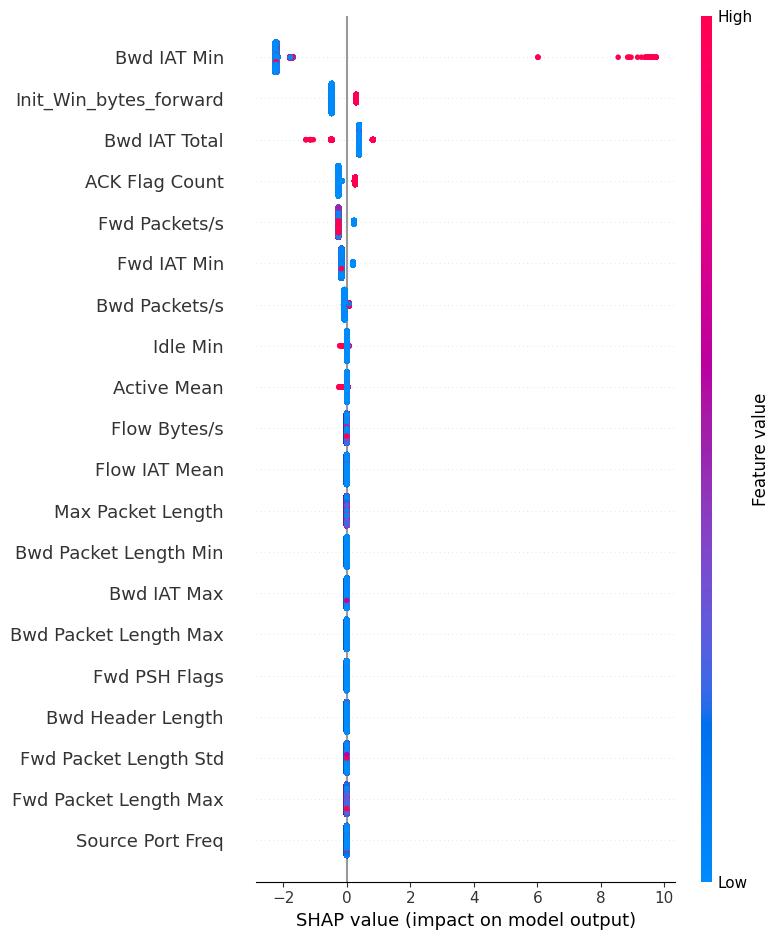

Cluster 23


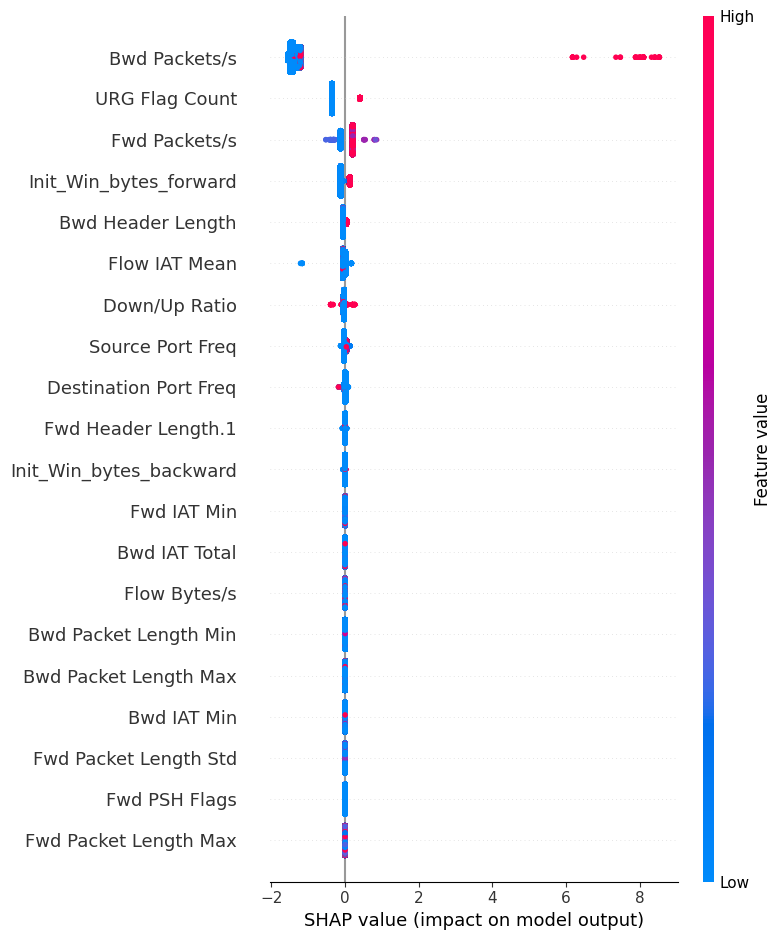

Cluster 24


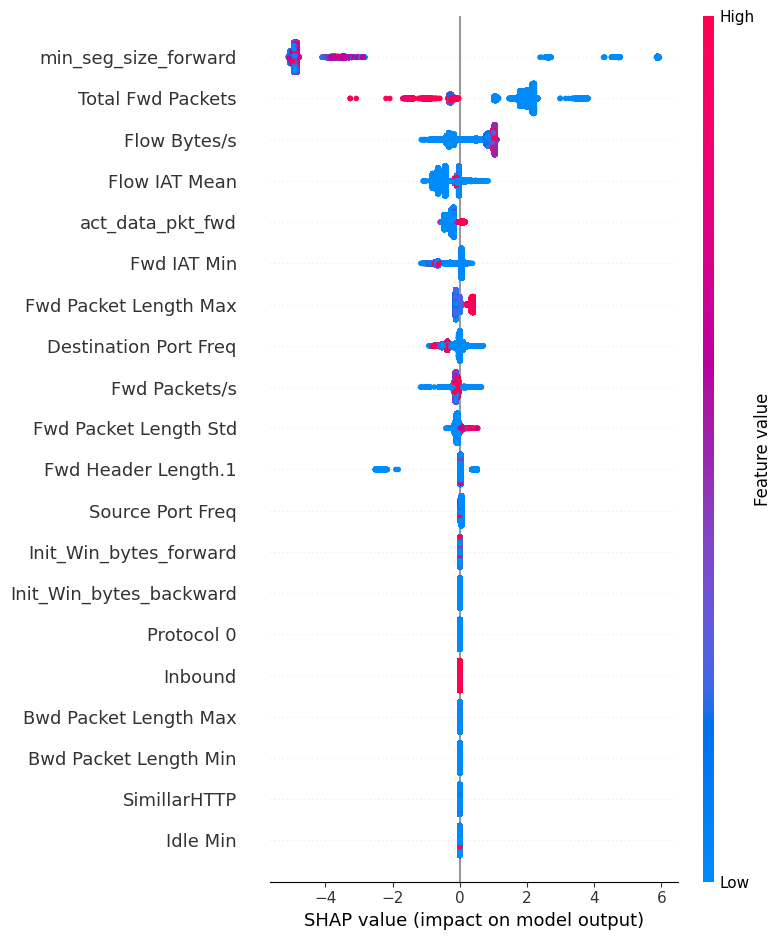

Cluster 25


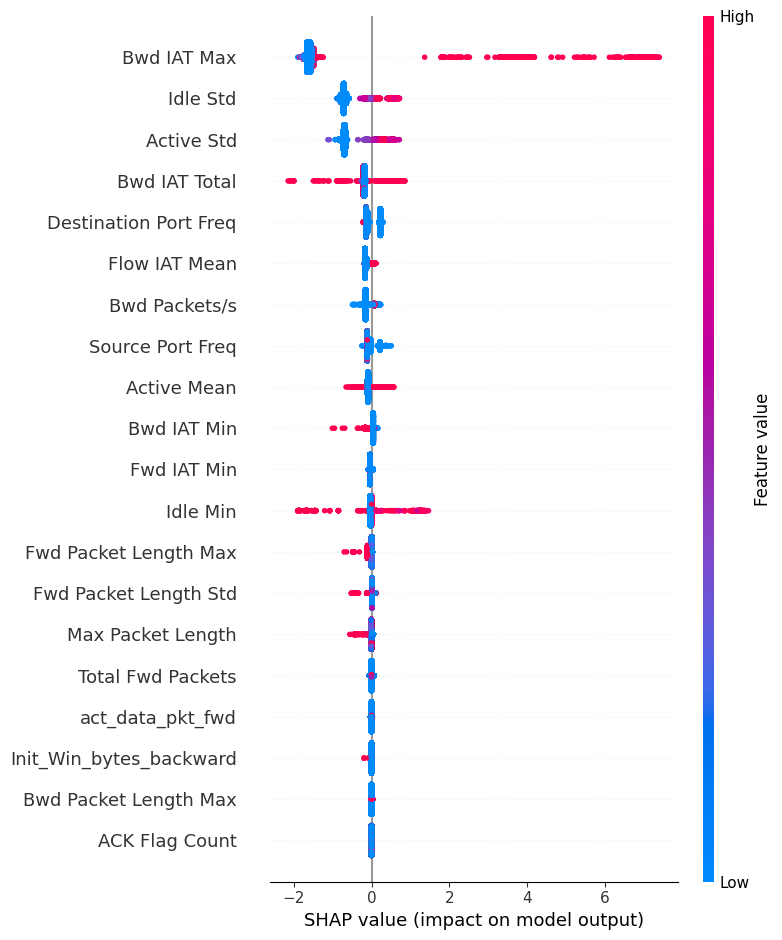

Cluster 26


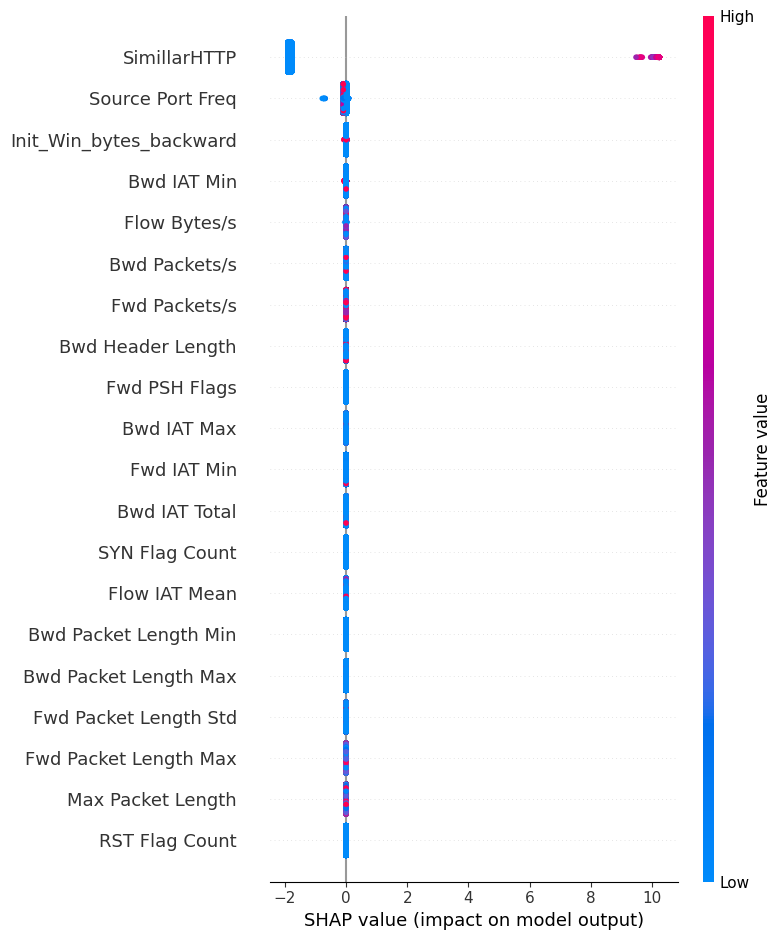

Cluster 27


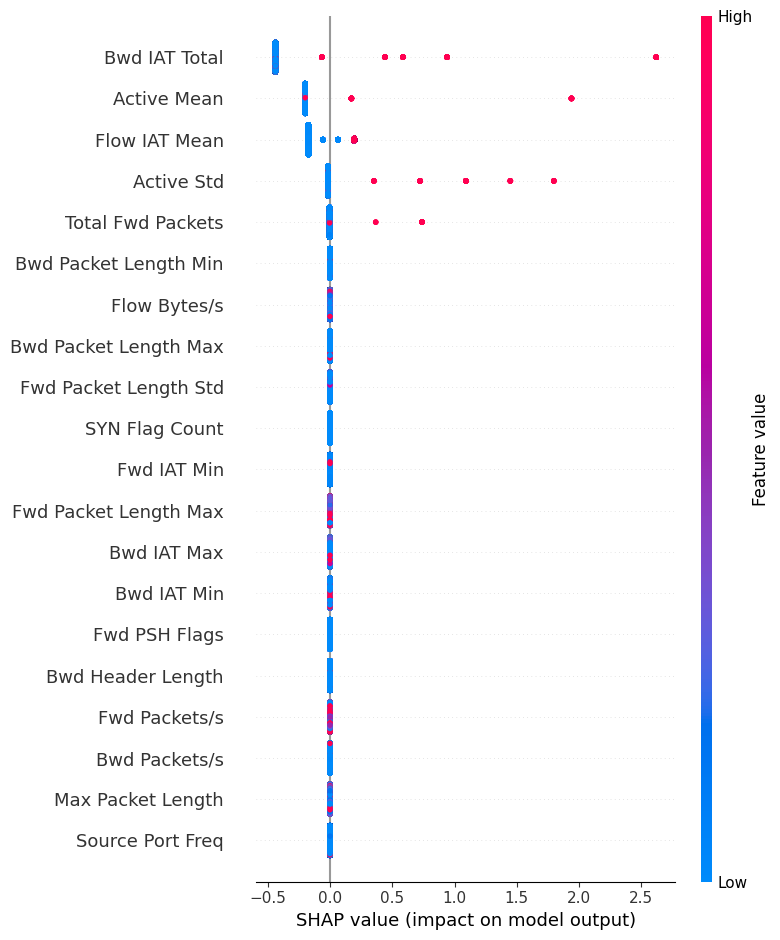

Cluster 28


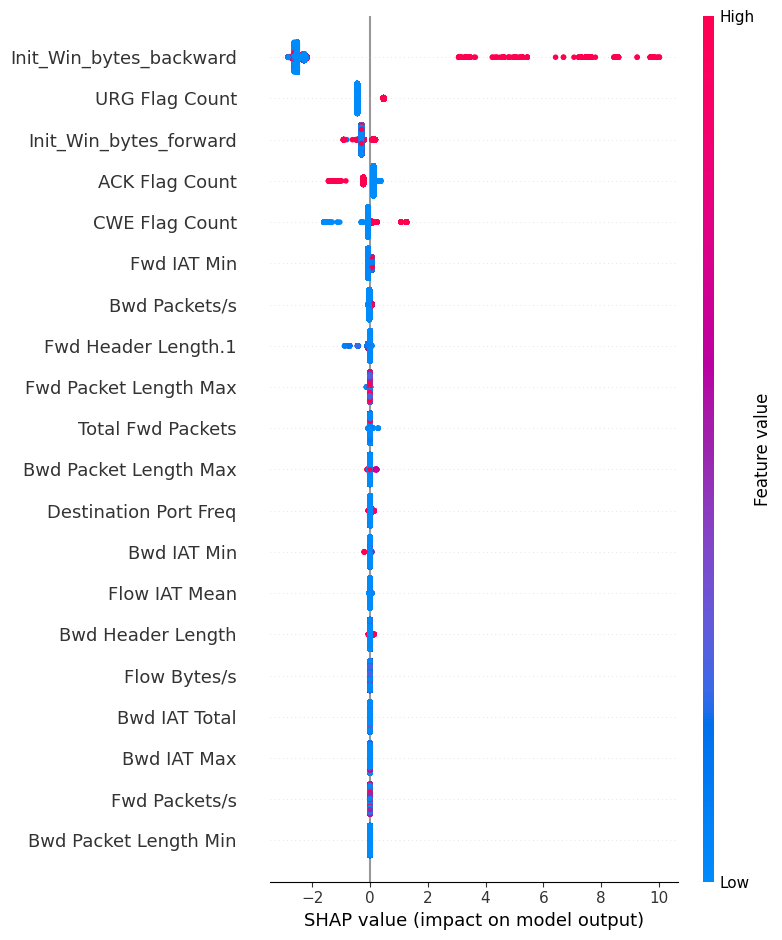

Cluster 29


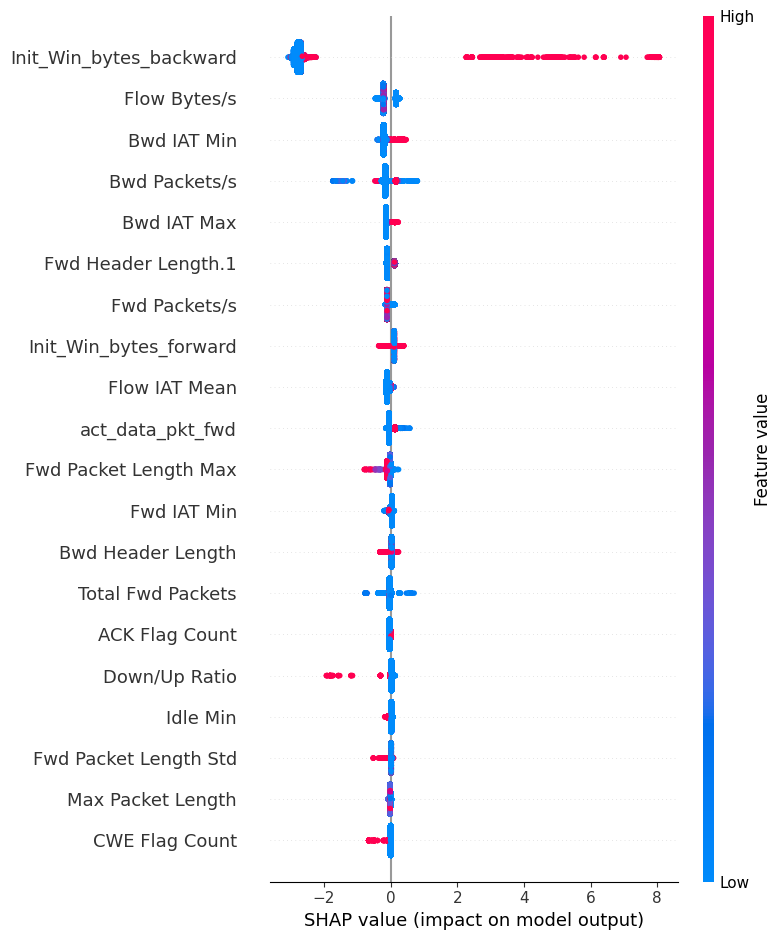

Cluster 30


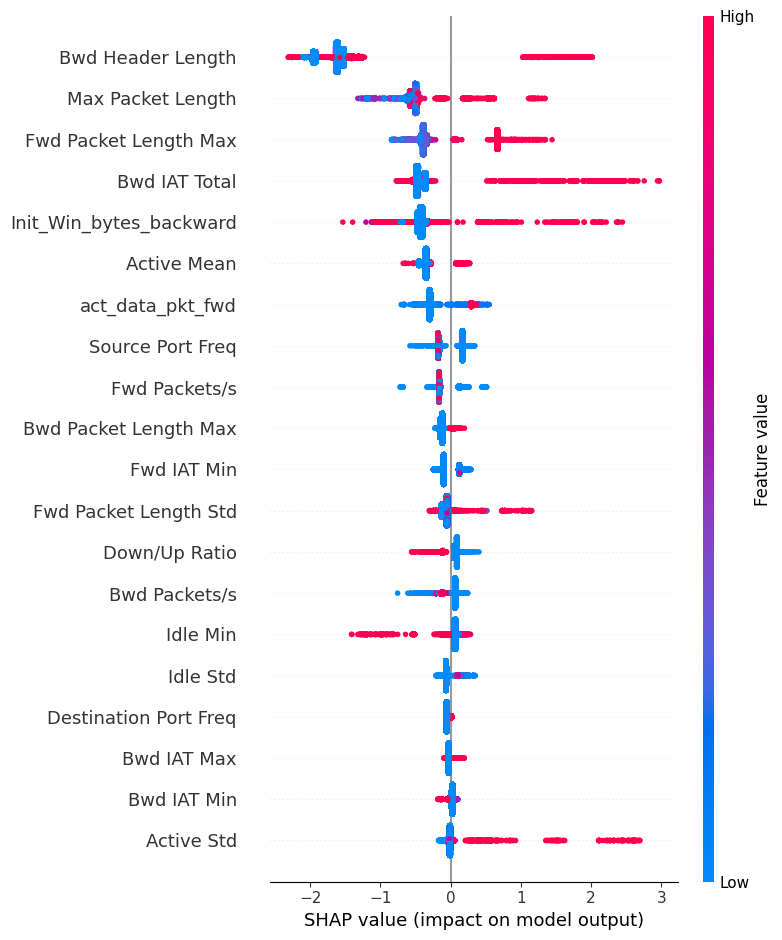

Cluster 31


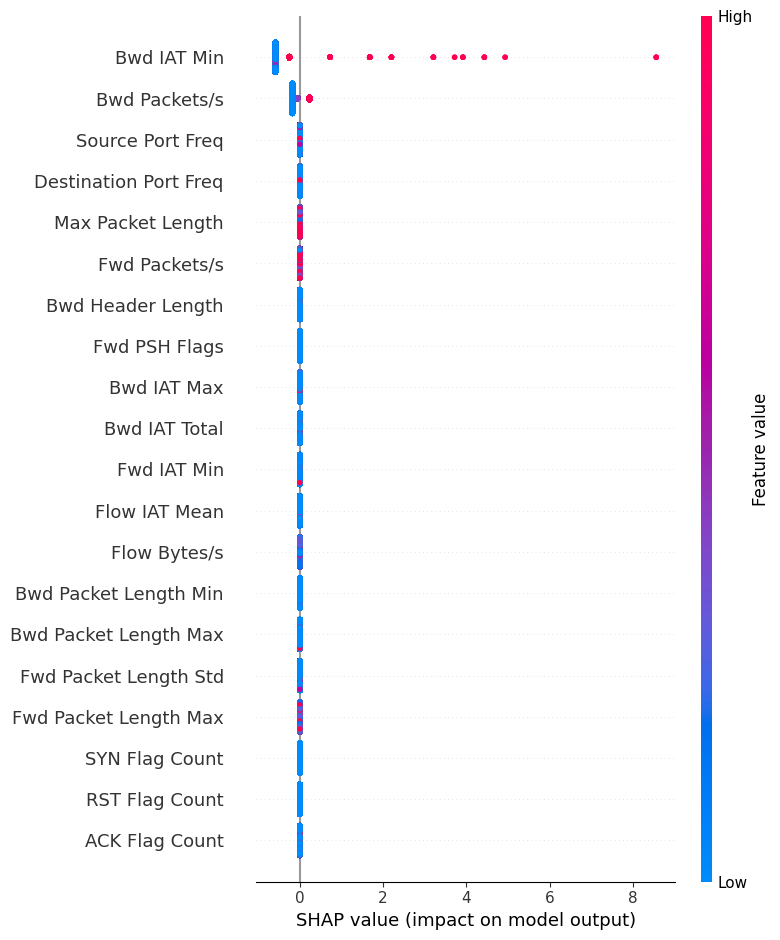

Cluster 32


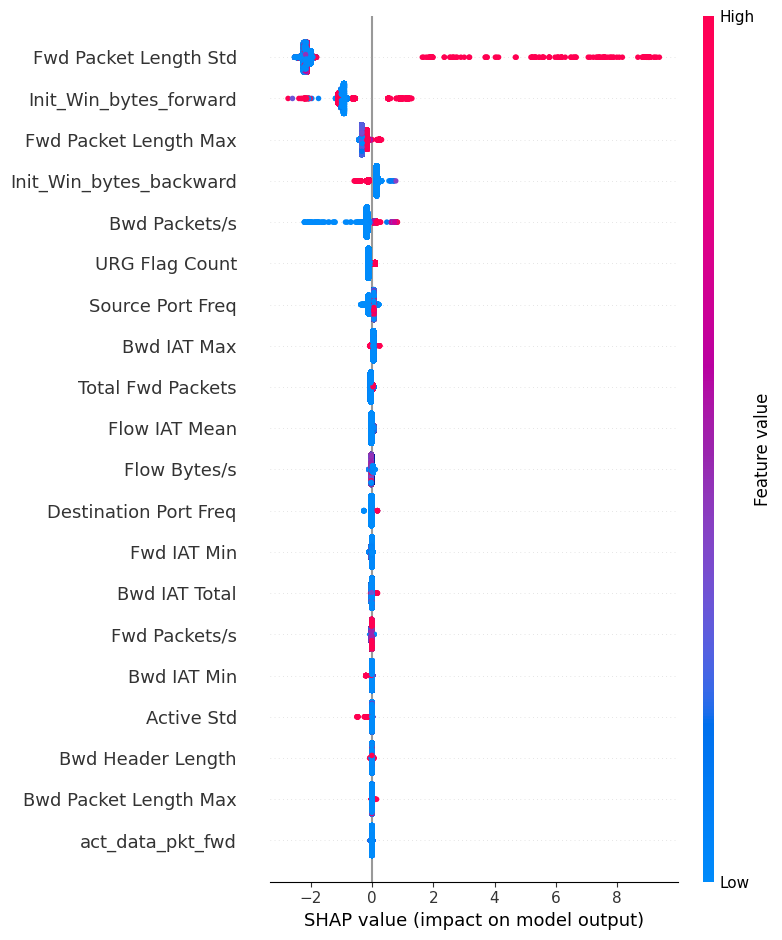

Cluster 33


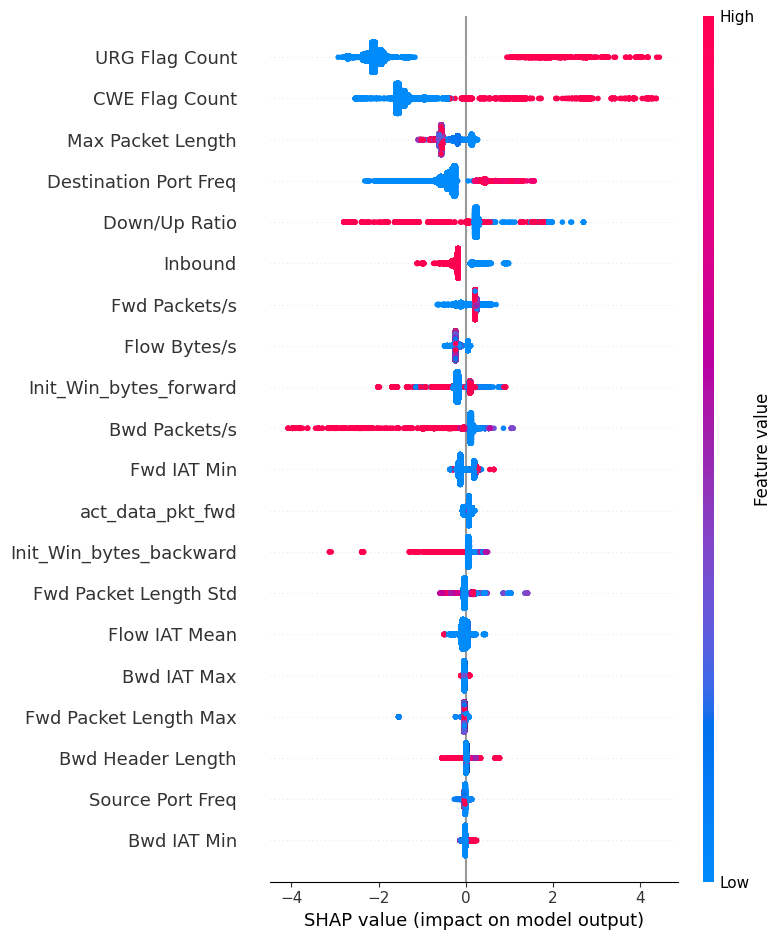

Cluster 34


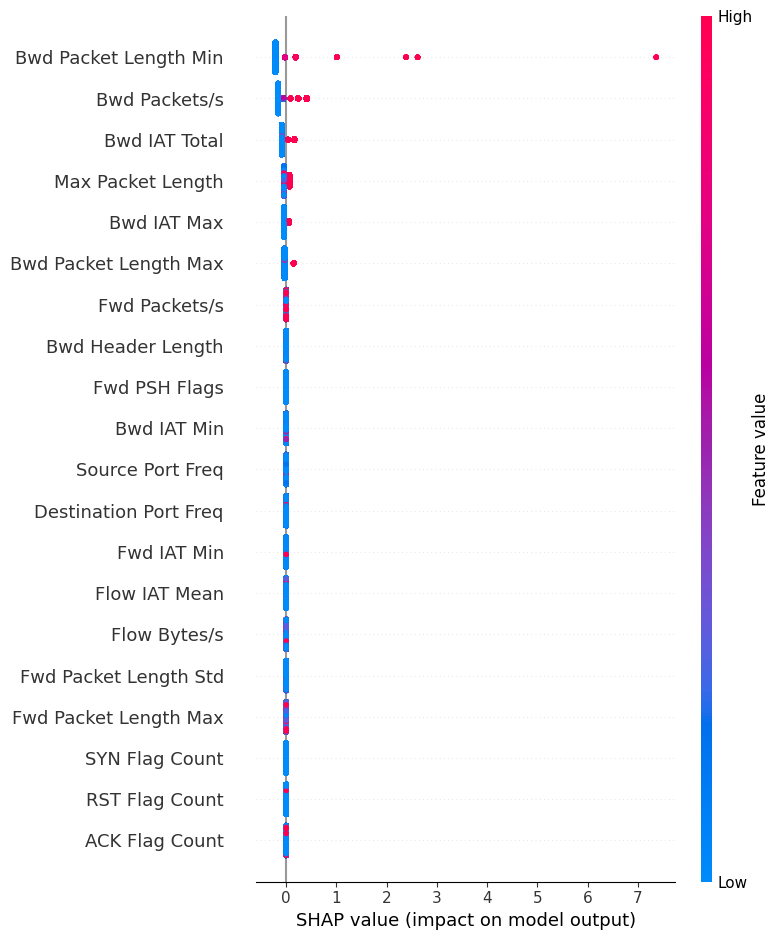

In [37]:
import shap
import xgboost as xgb

ddos_data_s = pd.DataFrame(X_s, columns=ddos_data.drop(columns=['label']).columns)

kmeans = KMeans(n_clusters=35, random_state=0)
cluster_labels = kmeans.fit_predict(X_s)

# Train a classifier with xgboost
model = xgb.XGBClassifier(random_state=42)
model.fit(ddos_data_s, cluster_labels)

# Create an object explainer SHAP and calculate the SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ddos_data_s)

# For each cluster
for i in range(model.n_classes_):
    print(f"Cluster {i}")
    shap.summary_plot(shap_values[i], ddos_data_s)